### In this notebook I have built a Neural Machine Transfer Model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25").

In [2]:
!pip install faker

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading and Preprocessing Data

In [2]:
fake = Faker()
Faker.seed(12345)
random.seed(12345)

In [3]:
# Defining the format of the data to be generated
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

In [4]:
# For working with Eng US we will set the parameter . To work with any other language we can change this parameter
LOCALES = ['en_US']

In [5]:
# Human Readable Dates are of the form ===>> "25th of June, 2009"
# Machine Readable Dates are of the form ===>> "2009-06-25"
# We will define a function that will load some fake dates and will return a tuple containing human readable string,
# machine readble string , date object
def load_date():
    dt = fake.date_object()
    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

In [6]:
# Now we will define a function to load (generate) the data
"""
    Loads a dataset with m examples and vocabularies
    :m: the number of examples to generate
"""
def load_dataset(m):
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],  # Dictionary that maps human readable dates to indices
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}      # Dictionary which maps machine readable dates to indices
 
    return dataset, human, machine, inv_machine

In [7]:
# We will train the model on 10,000 human readable dates and their equivalent, standardized, machine readable dates
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:01<00:00, 9361.11it/s]


In [8]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

Now we have loaded :
* dataset : a list of tuples containing (human readable dates, machine readable dates)
* human_vocab: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
* machine_vocab: a python dictionary mapping all characters used in machine readable dates to an integer-valued index.
* inv_machine_vocab: the inverse dictionary of machine_vocab, mapping from indices back to characters

We  will set Tx = 30 and Ty = 10 ("YYYY-MM-DD" is 10 characters long). We are assuming Tx is maximum length of sequence , if the sequence is longer we will truncate it.


In [9]:
Tx = 30
Ty = 10

In [10]:
# Converts all strings in the vocabulary into a list of integers representing the positions of the
# input string's characters in the "vocab"
    
def string_to_int(string, length, vocab):
    """
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


In [11]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)  # For unzipping (We had human,machine dates in dataset so to unzip them we use * with zip function)
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    # Converting X and Y to one hot vectors
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh


In [12]:
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. 
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >). 
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
    - `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation. 
    - `Yoh.shape = (m, Tx, len(machine_vocab))`. 
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

In [13]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Model Overview

We will build an attention mechanism. Suppose if we want to translate a book paragraph from Japanese sentence to English we would not read the whole paragraph, then close the book and translate. Even during the translation process, we would read/re-read and focus on the parts of the Japanese paragraph corresponding to the parts of the English you are writing down. The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

![](ss1.png)

To calculate the attention variables alpha we use a simple neural net like architecture as shown below

![](ss2.png)

We will create a function named one step attention that will be responsible for computing the attention weights and
calculating the context vector. 
The function model will call the layers in one step attention function $T_y$ times using a for loop

It is important that all $T_y$ copies have the same weights. 
* It should not reinitialize the weights every time. 
* In other words, all $T_y$ steps should have shared weights. 

For this purpose we will define the layer objects in a variable scope that is outside of the `one_step_attention` function.  For example, defining the objects as global variables.

In [14]:
# Softmax Activation Function
def softmax(x, axis=1):
    """
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
        

In [15]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') 
dotor = Dot(axes = 1)

In [16]:
# One Step Attention to calculate Attention Weights
# Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
# "alphas" and the hidden states "a" of the Bi-LSTM.
    
def one_step_attention(a, s_prev):
    """
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    # Repeating s_prev to be of shape (m, Tx, n_s) so that we can concatenate it with all hidden states "a" 
    s_prev = repeator(s_prev)
    # Concatenating a and s_prev on the last axis
    concat = concatenator([a,s_prev])
    e = densor1(concat) #compute the "intermediate energies" variable e.
    energies = densor2(e)
    alphas = activator(energies) # Producing the attention weights by passing energies through softmax
    context = dotor([alphas, a]) # Computing the context vector
    return context

Now we will create a model function 
* `model` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `model` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$. 

In [17]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

In [18]:
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense(len(machine_vocab), activation=softmax)

In [19]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    outputs = []
    # Step 1: Defining pre-attention Bi-LSTM.
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X) # return_sequences = True returns all the sequences i.e the a
    
    # Step 2: Iteratating for Ty steps
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    
    # Step 3: Creating the model instance taking three inputs and returning the list of outputs. 
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    return model

In [20]:
# creating the model
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          

In [22]:
# compiling the model
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt,
                    metrics=['accuracy'],
                    loss='categorical_crossentropy')

### Define the inputs and the outputs to fit the model
- Given the `model()` you coded, you need the "outputs" to be a list of 10 elements of shape (m, T_y). 
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). 
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [27]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))
print(outputs[0])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
model.fit([Xoh, s0, c0], outputs, epochs=30, batch_size=100)

Epoch 1/30


 2400/10000 [======>.......................] - ETA: 48:53 - loss: 24.0768 - dense_3_loss: 2.4017 - dense_3_accuracy: 0.0100 - dense_3_accuracy_1: 0.0000e+00 - dense_3_accuracy_2: 0.2000 - dense_3_accuracy_3: 0.0700 - dense_3_accuracy_4: 0.0000e+00 - dense_3_accuracy_5: 0.0100 - dense_3_accuracy_6: 0.0800 - dense_3_accuracy_7: 0.0000e+00 - dense_3_accuracy_8: 0.0000e+00 - dense_3_accuracy_9: 0.11 - ETA: 24:19 - loss: 23.8527 - dense_3_loss: 2.4143 - dense_3_accuracy: 0.0050 - dense_3_accuracy_1: 0.0000e+00 - dense_3_accuracy_2: 0.1000 - dense_3_accuracy_3: 0.0350 - dense_3_accuracy_4: 0.5000 - dense_3_accuracy_5: 0.0050 - dense_3_accuracy_6: 0.0400 - dense_3_accuracy_7: 0.5000 - dense_3_accuracy_8: 0.0000e+00 - dense_3_accuracy_9: 0.0550       - ETA: 16:08 - loss: 23.5969 - dense_3_loss: 2.4320 - dense_3_accuracy: 0.0033 - dense_3_accuracy_1: 0.0000e+00 - dense_3_accuracy_2: 0.0667 - dense_3_accuracy_3: 0.0233 - dense_3_accuracy_4: 0.6667 - dense_3_accuracy_5: 0.0033 - dense_3_accuracy_

 4800/10000 [=============>................] - ETA: 1:40 - loss: 21.3569 - dense_3_loss: 2.7769 - dense_3_accuracy: 8.0000e-04 - dense_3_accuracy_1: 0.3040 - dense_3_accuracy_2: 0.1064 - dense_3_accuracy_3: 0.0280 - dense_3_accuracy_4: 0.9216 - dense_3_accuracy_5: 4.0000e-04 - dense_3_accuracy_6: 0.0032 - dense_3_accuracy_7: 0.9600 - dense_3_accuracy_8: 0.0000e+00 - dense_3_accuracy_9: 0.004 - ETA: 1:36 - loss: 21.3045 - dense_3_loss: 2.7745 - dense_3_accuracy: 7.6923e-04 - dense_3_accuracy_1: 0.3173 - dense_3_accuracy_2: 0.1100 - dense_3_accuracy_3: 0.0285 - dense_3_accuracy_4: 0.9246 - dense_3_accuracy_5: 3.8462e-04 - dense_3_accuracy_6: 0.0031 - dense_3_accuracy_7: 0.9615 - dense_3_accuracy_8: 0.0027 - dense_3_accuracy_9: 0.0077    - ETA: 1:31 - loss: 21.2460 - dense_3_loss: 2.7686 - dense_3_accuracy: 7.4074e-04 - dense_3_accuracy_1: 0.3296 - dense_3_accuracy_2: 0.1170 - dense_3_accuracy_3: 0.0278 - dense_3_accuracy_4: 0.9274 - dense_3_accuracy_5: 3.7037e-04 - dense_3_accuracy_6: 0.

 7300/10000 [====================>.........] - ETA: 40s - loss: 20.0759 - dense_3_loss: 2.7151 - dense_3_accuracy: 0.1802 - dense_3_accuracy_1: 0.4731 - dense_3_accuracy_2: 0.2253 - dense_3_accuracy_3: 0.0431 - dense_3_accuracy_4: 0.9588 - dense_3_accuracy_5: 0.0014 - dense_3_accuracy_6: 0.0016 - dense_3_accuracy_7: 0.9716 - dense_3_accuracy_8: 0.0853 - dense_3_accuracy_9: 0.05 - ETA: 39s - loss: 20.0182 - dense_3_loss: 2.7125 - dense_3_accuracy: 0.1892 - dense_3_accuracy_1: 0.4790 - dense_3_accuracy_2: 0.2294 - dense_3_accuracy_3: 0.0422 - dense_3_accuracy_4: 0.9596 - dense_3_accuracy_5: 0.0014 - dense_3_accuracy_6: 0.0016 - dense_3_accuracy_7: 0.9722 - dense_3_accuracy_8: 0.0866 - dense_3_accuracy_9: 0.06 - ETA: 37s - loss: 19.9662 - dense_3_loss: 2.7088 - dense_3_accuracy: 0.1955 - dense_3_accuracy_1: 0.4837 - dense_3_accuracy_2: 0.2320 - dense_3_accuracy_3: 0.0424 - dense_3_accuracy_4: 0.9604 - dense_3_accuracy_5: 0.0014 - dense_3_accuracy_6: 0.0016 - dense_3_accuracy_7: 0.9722 - d

 9800/10000 [============================>.] - ETA: 15s - loss: 18.4813 - dense_3_loss: 2.6271 - dense_3_accuracy: 0.3689 - dense_3_accuracy_1: 0.6174 - dense_3_accuracy_2: 0.2843 - dense_3_accuracy_3: 0.0589 - dense_3_accuracy_4: 0.9581 - dense_3_accuracy_5: 0.1712 - dense_3_accuracy_6: 0.0053 - dense_3_accuracy_7: 0.9791 - dense_3_accuracy_8: 0.1626 - dense_3_accuracy_9: 0.08 - ETA: 14s - loss: 18.4122 - dense_3_loss: 2.6237 - dense_3_accuracy: 0.3747 - dense_3_accuracy_1: 0.6205 - dense_3_accuracy_2: 0.2857 - dense_3_accuracy_3: 0.0600 - dense_3_accuracy_4: 0.9587 - dense_3_accuracy_5: 0.1805 - dense_3_accuracy_6: 0.0065 - dense_3_accuracy_7: 0.9793 - dense_3_accuracy_8: 0.1652 - dense_3_accuracy_9: 0.08 - ETA: 13s - loss: 18.3423 - dense_3_loss: 2.6188 - dense_3_accuracy: 0.3820 - dense_3_accuracy_1: 0.6249 - dense_3_accuracy_2: 0.2874 - dense_3_accuracy_3: 0.0601 - dense_3_accuracy_4: 0.9592 - dense_3_accuracy_5: 0.1893 - dense_3_accuracy_6: 0.0076 - dense_3_accuracy_7: 0.9796 - d

10000/10000 [==============================] - ETA: 0s - loss: 16.7527 - dense_3_loss: 2.5486 - dense_3_accuracy: 0.5103 - dense_3_accuracy_1: 0.6996 - dense_3_accuracy_2: 0.3197 - dense_3_accuracy_3: 0.0738 - dense_3_accuracy_4: 0.9687 - dense_3_accuracy_5: 0.3325 - dense_3_accuracy_6: 0.0297 - dense_3_accuracy_7: 0.9843 - dense_3_accuracy_8: 0.2164 - dense_3_accuracy_9: 0.091 - 49s 5ms/step - loss: 16.6918 - dense_3_loss: 2.5460 - dense_3_accuracy: 0.5146 - dense_3_accuracy_1: 0.7021 - dense_3_accuracy_2: 0.3209 - dense_3_accuracy_3: 0.0741 - dense_3_accuracy_4: 0.9690 - dense_3_accuracy_5: 0.3372 - dense_3_accuracy_6: 0.0318 - dense_3_accuracy_7: 0.9845 - dense_3_accuracy_8: 0.2180 - dense_3_accuracy_9: 0.0912
Epoch 2/30


 2500/10000 [======>.......................] - ETA: 15s - loss: 10.2875 - dense_3_loss: 2.2793 - dense_3_accuracy: 0.9300 - dense_3_accuracy_1: 0.9100 - dense_3_accuracy_2: 0.4700 - dense_3_accuracy_3: 0.1500 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.8000 - dense_3_accuracy_6: 0.1500 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3400 - dense_3_accuracy_9: 0.18 - ETA: 15s - loss: 10.2738 - dense_3_loss: 2.2733 - dense_3_accuracy: 0.9500 - dense_3_accuracy_1: 0.9400 - dense_3_accuracy_2: 0.4700 - dense_3_accuracy_3: 0.1050 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.8500 - dense_3_accuracy_6: 0.1250 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3600 - dense_3_accuracy_9: 0.16 - ETA: 14s - loss: 10.3534 - dense_3_loss: 2.2650 - dense_3_accuracy: 0.9400 - dense_3_accuracy_1: 0.9400 - dense_3_accuracy_2: 0.4633 - dense_3_accuracy_3: 0.1133 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.8667 - dense_3_accuracy_6: 0.1100 - dense_3_accuracy_7: 1.0000 - d

 5000/10000 [==============>...............] - ETA: 11s - loss: 10.0239 - dense_3_loss: 2.2705 - dense_3_accuracy: 0.9554 - dense_3_accuracy_1: 0.9535 - dense_3_accuracy_2: 0.4785 - dense_3_accuracy_3: 0.1381 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9027 - dense_3_accuracy_6: 0.2104 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3712 - dense_3_accuracy_9: 0.14 - ETA: 11s - loss: 10.0079 - dense_3_loss: 2.2704 - dense_3_accuracy: 0.9563 - dense_3_accuracy_1: 0.9548 - dense_3_accuracy_2: 0.4796 - dense_3_accuracy_3: 0.1385 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9041 - dense_3_accuracy_6: 0.2096 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3726 - dense_3_accuracy_9: 0.14 - ETA: 11s - loss: 9.9897 - dense_3_loss: 2.2671 - dense_3_accuracy: 0.9571 - dense_3_accuracy_1: 0.9557 - dense_3_accuracy_2: 0.4818 - dense_3_accuracy_3: 0.1375 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9057 - dense_3_accuracy_6: 0.2096 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 7s - loss: 9.7468 - dense_3_loss: 2.2531 - dense_3_accuracy: 0.9584 - dense_3_accuracy_1: 0.9561 - dense_3_accuracy_2: 0.5014 - dense_3_accuracy_3: 0.1510 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9206 - dense_3_accuracy_6: 0.2308 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3839 - dense_3_accuracy_9: 0.15 - ETA: 7s - loss: 9.7343 - dense_3_loss: 2.2529 - dense_3_accuracy: 0.9585 - dense_3_accuracy_1: 0.9562 - dense_3_accuracy_2: 0.5015 - dense_3_accuracy_3: 0.1513 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9215 - dense_3_accuracy_6: 0.2296 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3871 - dense_3_accuracy_9: 0.15 - ETA: 7s - loss: 9.7236 - dense_3_loss: 2.2520 - dense_3_accuracy: 0.9585 - dense_3_accuracy_1: 0.9564 - dense_3_accuracy_2: 0.5028 - dense_3_accuracy_3: 0.1517 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9219 - dense_3_accuracy_6: 0.2298 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 9.5118 - dense_3_loss: 2.2392 - dense_3_accuracy: 0.9605 - dense_3_accuracy_1: 0.9593 - dense_3_accuracy_2: 0.5313 - dense_3_accuracy_3: 0.1613 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9325 - dense_3_accuracy_6: 0.2639 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3961 - dense_3_accuracy_9: 0.16 - ETA: 4s - loss: 9.5036 - dense_3_loss: 2.2386 - dense_3_accuracy: 0.9605 - dense_3_accuracy_1: 0.9595 - dense_3_accuracy_2: 0.5317 - dense_3_accuracy_3: 0.1614 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9330 - dense_3_accuracy_6: 0.2666 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.3961 - dense_3_accuracy_9: 0.16 - ETA: 4s - loss: 9.4959 - dense_3_loss: 2.2379 - dense_3_accuracy: 0.9608 - dense_3_accuracy_1: 0.9597 - dense_3_accuracy_2: 0.5336 - dense_3_accuracy_3: 0.1618 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9333 - dense_3_accuracy_6: 0.2673 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 3/30


 2500/10000 [======>.......................] - ETA: 22s - loss: 8.6505 - dense_3_loss: 2.1806 - dense_3_accuracy: 0.9700 - dense_3_accuracy_1: 0.9700 - dense_3_accuracy_2: 0.6800 - dense_3_accuracy_3: 0.2300 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.4400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4800 - dense_3_accuracy_9: 0.260 - ETA: 20s - loss: 8.6855 - dense_3_loss: 2.1392 - dense_3_accuracy: 0.9650 - dense_3_accuracy_1: 0.9650 - dense_3_accuracy_2: 0.6700 - dense_3_accuracy_3: 0.2200 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.3900 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4350 - dense_3_accuracy_9: 0.265 - ETA: 19s - loss: 8.6483 - dense_3_loss: 2.0947 - dense_3_accuracy: 0.9633 - dense_3_accuracy_1: 0.9633 - dense_3_accuracy_2: 0.6533 - dense_3_accuracy_3: 0.2167 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9633 - dense_3_accuracy_6: 0.4267 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 12s - loss: 8.3216 - dense_3_loss: 2.1084 - dense_3_accuracy: 0.9746 - dense_3_accuracy_1: 0.9735 - dense_3_accuracy_2: 0.6858 - dense_3_accuracy_3: 0.2269 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9604 - dense_3_accuracy_6: 0.4785 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4462 - dense_3_accuracy_9: 0.229 - ETA: 11s - loss: 8.3106 - dense_3_loss: 2.1075 - dense_3_accuracy: 0.9752 - dense_3_accuracy_1: 0.9737 - dense_3_accuracy_2: 0.6852 - dense_3_accuracy_3: 0.2281 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9615 - dense_3_accuracy_6: 0.4800 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4452 - dense_3_accuracy_9: 0.229 - ETA: 11s - loss: 8.3065 - dense_3_loss: 2.1066 - dense_3_accuracy: 0.9746 - dense_3_accuracy_1: 0.9732 - dense_3_accuracy_2: 0.6846 - dense_3_accuracy_3: 0.2289 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9621 - dense_3_accuracy_6: 0.4818 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 8s - loss: 8.1765 - dense_3_loss: 2.0832 - dense_3_accuracy: 0.9720 - dense_3_accuracy_1: 0.9712 - dense_3_accuracy_2: 0.7033 - dense_3_accuracy_3: 0.2516 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9624 - dense_3_accuracy_6: 0.4873 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4502 - dense_3_accuracy_9: 0.23 - ETA: 7s - loss: 8.1706 - dense_3_loss: 2.0821 - dense_3_accuracy: 0.9717 - dense_3_accuracy_1: 0.9712 - dense_3_accuracy_2: 0.7035 - dense_3_accuracy_3: 0.2521 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9625 - dense_3_accuracy_6: 0.4881 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4498 - dense_3_accuracy_9: 0.23 - ETA: 7s - loss: 8.1702 - dense_3_loss: 2.0809 - dense_3_accuracy: 0.9711 - dense_3_accuracy_1: 0.9706 - dense_3_accuracy_2: 0.7045 - dense_3_accuracy_3: 0.2532 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9625 - dense_3_accuracy_6: 0.4887 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 7.9848 - dense_3_loss: 2.0506 - dense_3_accuracy: 0.9712 - dense_3_accuracy_1: 0.9712 - dense_3_accuracy_2: 0.7237 - dense_3_accuracy_3: 0.2736 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9641 - dense_3_accuracy_6: 0.5078 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4620 - dense_3_accuracy_9: 0.24 - ETA: 4s - loss: 7.9756 - dense_3_loss: 2.0486 - dense_3_accuracy: 0.9713 - dense_3_accuracy_1: 0.9713 - dense_3_accuracy_2: 0.7252 - dense_3_accuracy_3: 0.2755 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9642 - dense_3_accuracy_6: 0.5086 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4618 - dense_3_accuracy_9: 0.25 - ETA: 3s - loss: 7.9632 - dense_3_loss: 2.0466 - dense_3_accuracy: 0.9717 - dense_3_accuracy_1: 0.9717 - dense_3_accuracy_2: 0.7254 - dense_3_accuracy_3: 0.2763 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9644 - dense_3_accuracy_6: 0.5091 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 4/30


 2500/10000 [======>.......................] - ETA: 15s - loss: 7.0093 - dense_3_loss: 1.9135 - dense_3_accuracy: 0.9600 - dense_3_accuracy_1: 0.9600 - dense_3_accuracy_2: 0.8500 - dense_3_accuracy_3: 0.3100 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9600 - dense_3_accuracy_6: 0.5900 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.4800 - dense_3_accuracy_9: 0.240 - ETA: 15s - loss: 6.9540 - dense_3_loss: 1.8680 - dense_3_accuracy: 0.9750 - dense_3_accuracy_1: 0.9800 - dense_3_accuracy_2: 0.8050 - dense_3_accuracy_3: 0.3600 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9500 - dense_3_accuracy_6: 0.6400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5300 - dense_3_accuracy_9: 0.310 - ETA: 15s - loss: 6.9875 - dense_3_loss: 1.8684 - dense_3_accuracy: 0.9700 - dense_3_accuracy_1: 0.9767 - dense_3_accuracy_2: 0.8133 - dense_3_accuracy_3: 0.3633 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9533 - dense_3_accuracy_6: 0.6367 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 12s - loss: 6.8101 - dense_3_loss: 1.8068 - dense_3_accuracy: 0.9712 - dense_3_accuracy_1: 0.9727 - dense_3_accuracy_2: 0.8150 - dense_3_accuracy_3: 0.3765 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9669 - dense_3_accuracy_6: 0.6412 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5477 - dense_3_accuracy_9: 0.365 - ETA: 12s - loss: 6.8026 - dense_3_loss: 1.8087 - dense_3_accuracy: 0.9711 - dense_3_accuracy_1: 0.9726 - dense_3_accuracy_2: 0.8159 - dense_3_accuracy_3: 0.3804 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9670 - dense_3_accuracy_6: 0.6433 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5474 - dense_3_accuracy_9: 0.364 - ETA: 12s - loss: 6.7839 - dense_3_loss: 1.8073 - dense_3_accuracy: 0.9718 - dense_3_accuracy_1: 0.9736 - dense_3_accuracy_2: 0.8175 - dense_3_accuracy_3: 0.3839 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9679 - dense_3_accuracy_6: 0.6418 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 8s - loss: 6.5684 - dense_3_loss: 1.7516 - dense_3_accuracy: 0.9743 - dense_3_accuracy_1: 0.9763 - dense_3_accuracy_2: 0.8265 - dense_3_accuracy_3: 0.4165 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9692 - dense_3_accuracy_6: 0.6590 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5514 - dense_3_accuracy_9: 0.38 - ETA: 8s - loss: 6.5576 - dense_3_loss: 1.7469 - dense_3_accuracy: 0.9740 - dense_3_accuracy_1: 0.9762 - dense_3_accuracy_2: 0.8254 - dense_3_accuracy_3: 0.4204 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9694 - dense_3_accuracy_6: 0.6600 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5517 - dense_3_accuracy_9: 0.38 - ETA: 7s - loss: 6.5440 - dense_3_loss: 1.7444 - dense_3_accuracy: 0.9742 - dense_3_accuracy_1: 0.9764 - dense_3_accuracy_2: 0.8266 - dense_3_accuracy_3: 0.4211 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9700 - dense_3_accuracy_6: 0.6613 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 6.3533 - dense_3_loss: 1.6784 - dense_3_accuracy: 0.9750 - dense_3_accuracy_1: 0.9764 - dense_3_accuracy_2: 0.8355 - dense_3_accuracy_3: 0.4451 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9671 - dense_3_accuracy_6: 0.6637 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5642 - dense_3_accuracy_9: 0.41 - ETA: 3s - loss: 6.3437 - dense_3_loss: 1.6743 - dense_3_accuracy: 0.9749 - dense_3_accuracy_1: 0.9762 - dense_3_accuracy_2: 0.8358 - dense_3_accuracy_3: 0.4456 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9674 - dense_3_accuracy_6: 0.6634 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5647 - dense_3_accuracy_9: 0.41 - ETA: 3s - loss: 6.3327 - dense_3_loss: 1.6713 - dense_3_accuracy: 0.9751 - dense_3_accuracy_1: 0.9765 - dense_3_accuracy_2: 0.8373 - dense_3_accuracy_3: 0.4462 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9672 - dense_3_accuracy_6: 0.6636 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 5/30


 2500/10000 [======>.......................] - ETA: 16s - loss: 5.5463 - dense_3_loss: 1.3898 - dense_3_accuracy: 0.9800 - dense_3_accuracy_1: 0.9900 - dense_3_accuracy_2: 0.9100 - dense_3_accuracy_3: 0.5600 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9500 - dense_3_accuracy_6: 0.6500 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.5900 - dense_3_accuracy_9: 0.510 - ETA: 16s - loss: 5.3581 - dense_3_loss: 1.2832 - dense_3_accuracy: 0.9700 - dense_3_accuracy_1: 0.9900 - dense_3_accuracy_2: 0.9150 - dense_3_accuracy_3: 0.5350 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9600 - dense_3_accuracy_6: 0.6650 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.6100 - dense_3_accuracy_9: 0.555 - ETA: 17s - loss: 5.3171 - dense_3_loss: 1.2613 - dense_3_accuracy: 0.9733 - dense_3_accuracy_1: 0.9867 - dense_3_accuracy_2: 0.9100 - dense_3_accuracy_3: 0.5533 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9600 - dense_3_accuracy_6: 0.6467 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 13s - loss: 5.1357 - dense_3_loss: 1.2304 - dense_3_accuracy: 0.9738 - dense_3_accuracy_1: 0.9773 - dense_3_accuracy_2: 0.8677 - dense_3_accuracy_3: 0.6231 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9681 - dense_3_accuracy_6: 0.6992 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.6465 - dense_3_accuracy_9: 0.580 - ETA: 13s - loss: 5.1310 - dense_3_loss: 1.2255 - dense_3_accuracy: 0.9741 - dense_3_accuracy_1: 0.9774 - dense_3_accuracy_2: 0.8685 - dense_3_accuracy_3: 0.6230 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9670 - dense_3_accuracy_6: 0.6967 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.6481 - dense_3_accuracy_9: 0.581 - ETA: 12s - loss: 5.1158 - dense_3_loss: 1.2248 - dense_3_accuracy: 0.9750 - dense_3_accuracy_1: 0.9779 - dense_3_accuracy_2: 0.8682 - dense_3_accuracy_3: 0.6246 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9675 - dense_3_accuracy_6: 0.6961 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 8s - loss: 4.9417 - dense_3_loss: 1.1785 - dense_3_accuracy: 0.9780 - dense_3_accuracy_1: 0.9814 - dense_3_accuracy_2: 0.8725 - dense_3_accuracy_3: 0.6447 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9708 - dense_3_accuracy_6: 0.7180 - dense_3_accuracy_7: 0.9998 - dense_3_accuracy_8: 0.6588 - dense_3_accuracy_9: 0.59 - ETA: 8s - loss: 4.9337 - dense_3_loss: 1.1761 - dense_3_accuracy: 0.9781 - dense_3_accuracy_1: 0.9815 - dense_3_accuracy_2: 0.8719 - dense_3_accuracy_3: 0.6467 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9710 - dense_3_accuracy_6: 0.7181 - dense_3_accuracy_7: 0.9998 - dense_3_accuracy_8: 0.6588 - dense_3_accuracy_9: 0.59 - ETA: 8s - loss: 4.9314 - dense_3_loss: 1.1766 - dense_3_accuracy: 0.9781 - dense_3_accuracy_1: 0.9815 - dense_3_accuracy_2: 0.8721 - dense_3_accuracy_3: 0.6479 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9706 - dense_3_accuracy_6: 0.7191 - dense_3_accuracy_7: 0.9998 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 4.7897 - dense_3_loss: 1.1314 - dense_3_accuracy: 0.9772 - dense_3_accuracy_1: 0.9803 - dense_3_accuracy_2: 0.8696 - dense_3_accuracy_3: 0.6762 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9704 - dense_3_accuracy_6: 0.7196 - dense_3_accuracy_7: 0.9999 - dense_3_accuracy_8: 0.6696 - dense_3_accuracy_9: 0.61 - ETA: 4s - loss: 4.7859 - dense_3_loss: 1.1289 - dense_3_accuracy: 0.9770 - dense_3_accuracy_1: 0.9801 - dense_3_accuracy_2: 0.8701 - dense_3_accuracy_3: 0.6760 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9697 - dense_3_accuracy_6: 0.7199 - dense_3_accuracy_7: 0.9999 - dense_3_accuracy_8: 0.6700 - dense_3_accuracy_9: 0.61 - ETA: 4s - loss: 4.7838 - dense_3_loss: 1.1281 - dense_3_accuracy: 0.9765 - dense_3_accuracy_1: 0.9800 - dense_3_accuracy_2: 0.8696 - dense_3_accuracy_3: 0.6759 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9697 - dense_3_accuracy_6: 0.7199 - dense_3_accuracy_7: 0.9999 - dense_3

Epoch 6/30


 2500/10000 [======>.......................] - ETA: 19s - loss: 4.5599 - dense_3_loss: 0.8372 - dense_3_accuracy: 0.9500 - dense_3_accuracy_1: 0.9500 - dense_3_accuracy_2: 0.8700 - dense_3_accuracy_3: 0.8000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9500 - dense_3_accuracy_6: 0.7400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7100 - dense_3_accuracy_9: 0.730 - ETA: 18s - loss: 4.2163 - dense_3_loss: 0.7962 - dense_3_accuracy: 0.9550 - dense_3_accuracy_1: 0.9500 - dense_3_accuracy_2: 0.8750 - dense_3_accuracy_3: 0.7800 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9600 - dense_3_accuracy_6: 0.7800 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7550 - dense_3_accuracy_9: 0.765 - ETA: 17s - loss: 4.1663 - dense_3_loss: 0.8052 - dense_3_accuracy: 0.9600 - dense_3_accuracy_1: 0.9567 - dense_3_accuracy_2: 0.8733 - dense_3_accuracy_3: 0.7767 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9667 - dense_3_accuracy_6: 0.8100 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 14s - loss: 3.9512 - dense_3_loss: 0.8649 - dense_3_accuracy: 0.9731 - dense_3_accuracy_1: 0.9781 - dense_3_accuracy_2: 0.8873 - dense_3_accuracy_3: 0.7988 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9642 - dense_3_accuracy_6: 0.7904 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7027 - dense_3_accuracy_9: 0.726 - ETA: 15s - loss: 3.9463 - dense_3_loss: 0.8618 - dense_3_accuracy: 0.9730 - dense_3_accuracy_1: 0.9778 - dense_3_accuracy_2: 0.8867 - dense_3_accuracy_3: 0.7978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9641 - dense_3_accuracy_6: 0.7911 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7022 - dense_3_accuracy_9: 0.728 - ETA: 15s - loss: 3.9323 - dense_3_loss: 0.8602 - dense_3_accuracy: 0.9736 - dense_3_accuracy_1: 0.9782 - dense_3_accuracy_2: 0.8864 - dense_3_accuracy_3: 0.7968 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9646 - dense_3_accuracy_6: 0.7904 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 10s - loss: 3.7542 - dense_3_loss: 0.8081 - dense_3_accuracy: 0.9775 - dense_3_accuracy_1: 0.9810 - dense_3_accuracy_2: 0.8876 - dense_3_accuracy_3: 0.8178 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9686 - dense_3_accuracy_6: 0.7931 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7294 - dense_3_accuracy_9: 0.747 - ETA: 9s - loss: 3.7457 - dense_3_loss: 0.8062 - dense_3_accuracy: 0.9777 - dense_3_accuracy_1: 0.9812 - dense_3_accuracy_2: 0.8887 - dense_3_accuracy_3: 0.8181 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9690 - dense_3_accuracy_6: 0.7937 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7300 - dense_3_accuracy_9: 0.747 - ETA: 9s - loss: 3.7485 - dense_3_loss: 0.8053 - dense_3_accuracy: 0.9770 - dense_3_accuracy_1: 0.9804 - dense_3_accuracy_2: 0.8879 - dense_3_accuracy_3: 0.8191 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9692 - dense_3_accuracy_6: 0.7940 - dense_3_accuracy_7: 1.0000 - dens

10000/10000 [==============================] - ETA: 4s - loss: 3.6526 - dense_3_loss: 0.7756 - dense_3_accuracy: 0.9757 - dense_3_accuracy_1: 0.9809 - dense_3_accuracy_2: 0.8905 - dense_3_accuracy_3: 0.8296 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9724 - dense_3_accuracy_6: 0.7964 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7395 - dense_3_accuracy_9: 0.76 - ETA: 4s - loss: 3.6550 - dense_3_loss: 0.7753 - dense_3_accuracy: 0.9753 - dense_3_accuracy_1: 0.9806 - dense_3_accuracy_2: 0.8899 - dense_3_accuracy_3: 0.8295 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9719 - dense_3_accuracy_6: 0.7957 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7403 - dense_3_accuracy_9: 0.76 - ETA: 4s - loss: 3.6543 - dense_3_loss: 0.7738 - dense_3_accuracy: 0.9751 - dense_3_accuracy_1: 0.9804 - dense_3_accuracy_2: 0.8894 - dense_3_accuracy_3: 0.8301 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9717 - dense_3_accuracy_6: 0.7951 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 7/30


 2500/10000 [======>.......................] - ETA: 14s - loss: 2.7448 - dense_3_loss: 0.4986 - dense_3_accuracy: 0.9800 - dense_3_accuracy_1: 0.9900 - dense_3_accuracy_2: 0.9500 - dense_3_accuracy_3: 0.9000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.8200 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8100 - dense_3_accuracy_9: 0.830 - ETA: 14s - loss: 2.8608 - dense_3_loss: 0.4837 - dense_3_accuracy: 0.9650 - dense_3_accuracy_1: 0.9800 - dense_3_accuracy_2: 0.9150 - dense_3_accuracy_3: 0.9000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9950 - dense_3_accuracy_6: 0.8100 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8200 - dense_3_accuracy_9: 0.870 - ETA: 15s - loss: 2.9666 - dense_3_loss: 0.5086 - dense_3_accuracy: 0.9700 - dense_3_accuracy_1: 0.9833 - dense_3_accuracy_2: 0.9000 - dense_3_accuracy_3: 0.8900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.8000 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 13s - loss: 3.0192 - dense_3_loss: 0.5854 - dense_3_accuracy: 0.9781 - dense_3_accuracy_1: 0.9835 - dense_3_accuracy_2: 0.9000 - dense_3_accuracy_3: 0.8950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9715 - dense_3_accuracy_6: 0.8312 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7838 - dense_3_accuracy_9: 0.828 - ETA: 13s - loss: 3.0160 - dense_3_loss: 0.5844 - dense_3_accuracy: 0.9781 - dense_3_accuracy_1: 0.9841 - dense_3_accuracy_2: 0.8989 - dense_3_accuracy_3: 0.8944 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9726 - dense_3_accuracy_6: 0.8322 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7856 - dense_3_accuracy_9: 0.829 - ETA: 13s - loss: 3.0120 - dense_3_loss: 0.5809 - dense_3_accuracy: 0.9779 - dense_3_accuracy_1: 0.9839 - dense_3_accuracy_2: 0.8982 - dense_3_accuracy_3: 0.8954 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9714 - dense_3_accuracy_6: 0.8311 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 9s - loss: 2.9475 - dense_3_loss: 0.5620 - dense_3_accuracy: 0.9780 - dense_3_accuracy_1: 0.9837 - dense_3_accuracy_2: 0.9069 - dense_3_accuracy_3: 0.8961 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9727 - dense_3_accuracy_6: 0.8329 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7925 - dense_3_accuracy_9: 0.84 - ETA: 8s - loss: 2.9440 - dense_3_loss: 0.5611 - dense_3_accuracy: 0.9779 - dense_3_accuracy_1: 0.9838 - dense_3_accuracy_2: 0.9071 - dense_3_accuracy_3: 0.8969 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9729 - dense_3_accuracy_6: 0.8327 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7929 - dense_3_accuracy_9: 0.84 - ETA: 8s - loss: 2.9359 - dense_3_loss: 0.5590 - dense_3_accuracy: 0.9781 - dense_3_accuracy_1: 0.9842 - dense_3_accuracy_2: 0.9072 - dense_3_accuracy_3: 0.8974 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9728 - dense_3_accuracy_6: 0.8328 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 2.8355 - dense_3_loss: 0.5363 - dense_3_accuracy: 0.9786 - dense_3_accuracy_1: 0.9843 - dense_3_accuracy_2: 0.9162 - dense_3_accuracy_3: 0.9014 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9754 - dense_3_accuracy_6: 0.8441 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7991 - dense_3_accuracy_9: 0.84 - ETA: 4s - loss: 2.8351 - dense_3_loss: 0.5359 - dense_3_accuracy: 0.9782 - dense_3_accuracy_1: 0.9840 - dense_3_accuracy_2: 0.9165 - dense_3_accuracy_3: 0.9016 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9749 - dense_3_accuracy_6: 0.8439 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.7996 - dense_3_accuracy_9: 0.84 - ETA: 4s - loss: 2.8306 - dense_3_loss: 0.5351 - dense_3_accuracy: 0.9785 - dense_3_accuracy_1: 0.9842 - dense_3_accuracy_2: 0.9164 - dense_3_accuracy_3: 0.9024 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9749 - dense_3_accuracy_6: 0.8441 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 8/30


 2500/10000 [======>.......................] - ETA: 19s - loss: 2.4539 - dense_3_loss: 0.3546 - dense_3_accuracy: 0.9800 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9300 - dense_3_accuracy_3: 0.9800 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.8200 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8100 - dense_3_accuracy_9: 0.930 - ETA: 18s - loss: 2.4586 - dense_3_loss: 0.3902 - dense_3_accuracy: 0.9750 - dense_3_accuracy_1: 0.9800 - dense_3_accuracy_2: 0.9350 - dense_3_accuracy_3: 0.9600 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.8450 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8250 - dense_3_accuracy_9: 0.900 - ETA: 18s - loss: 2.5304 - dense_3_loss: 0.3932 - dense_3_accuracy: 0.9700 - dense_3_accuracy_1: 0.9733 - dense_3_accuracy_2: 0.9233 - dense_3_accuracy_3: 0.9433 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9700 - dense_3_accuracy_6: 0.8567 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 14s - loss: 2.4574 - dense_3_loss: 0.4264 - dense_3_accuracy: 0.9769 - dense_3_accuracy_1: 0.9854 - dense_3_accuracy_2: 0.9304 - dense_3_accuracy_3: 0.9338 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9727 - dense_3_accuracy_6: 0.8677 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8185 - dense_3_accuracy_9: 0.878 - ETA: 14s - loss: 2.4632 - dense_3_loss: 0.4275 - dense_3_accuracy: 0.9778 - dense_3_accuracy_1: 0.9859 - dense_3_accuracy_2: 0.9311 - dense_3_accuracy_3: 0.9333 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9726 - dense_3_accuracy_6: 0.8670 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8159 - dense_3_accuracy_9: 0.879 - ETA: 14s - loss: 2.4580 - dense_3_loss: 0.4254 - dense_3_accuracy: 0.9775 - dense_3_accuracy_1: 0.9857 - dense_3_accuracy_2: 0.9311 - dense_3_accuracy_3: 0.9321 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9732 - dense_3_accuracy_6: 0.8675 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 9s - loss: 2.3851 - dense_3_loss: 0.4109 - dense_3_accuracy: 0.9792 - dense_3_accuracy_1: 0.9859 - dense_3_accuracy_2: 0.9359 - dense_3_accuracy_3: 0.9286 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9763 - dense_3_accuracy_6: 0.8702 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8202 - dense_3_accuracy_9: 0.886 - ETA: 9s - loss: 2.3795 - dense_3_loss: 0.4098 - dense_3_accuracy: 0.9794 - dense_3_accuracy_1: 0.9860 - dense_3_accuracy_2: 0.9362 - dense_3_accuracy_3: 0.9288 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9763 - dense_3_accuracy_6: 0.8710 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8204 - dense_3_accuracy_9: 0.88 - ETA: 9s - loss: 2.3718 - dense_3_loss: 0.4090 - dense_3_accuracy: 0.9798 - dense_3_accuracy_1: 0.9862 - dense_3_accuracy_2: 0.9368 - dense_3_accuracy_3: 0.9289 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9760 - dense_3_accuracy_6: 0.8708 - dense_3_accuracy_7: 1.0000 - dense_

10000/10000 [==============================] - ETA: 4s - loss: 2.3175 - dense_3_loss: 0.4038 - dense_3_accuracy: 0.9804 - dense_3_accuracy_1: 0.9870 - dense_3_accuracy_2: 0.9392 - dense_3_accuracy_3: 0.9296 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9763 - dense_3_accuracy_6: 0.8763 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8288 - dense_3_accuracy_9: 0.88 - ETA: 4s - loss: 2.3155 - dense_3_loss: 0.4054 - dense_3_accuracy: 0.9803 - dense_3_accuracy_1: 0.9870 - dense_3_accuracy_2: 0.9395 - dense_3_accuracy_3: 0.9297 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9766 - dense_3_accuracy_6: 0.8766 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8296 - dense_3_accuracy_9: 0.88 - ETA: 4s - loss: 2.3145 - dense_3_loss: 0.4049 - dense_3_accuracy: 0.9804 - dense_3_accuracy_1: 0.9871 - dense_3_accuracy_2: 0.9396 - dense_3_accuracy_3: 0.9294 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9765 - dense_3_accuracy_6: 0.8769 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 9/30


 2500/10000 [======>.......................] - ETA: 16s - loss: 2.0513 - dense_3_loss: 0.2769 - dense_3_accuracy: 0.9800 - dense_3_accuracy_1: 0.9800 - dense_3_accuracy_2: 0.9500 - dense_3_accuracy_3: 0.9100 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9700 - dense_3_accuracy_6: 0.9000 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8200 - dense_3_accuracy_9: 0.950 - ETA: 16s - loss: 2.0253 - dense_3_loss: 0.3096 - dense_3_accuracy: 0.9850 - dense_3_accuracy_1: 0.9850 - dense_3_accuracy_2: 0.9550 - dense_3_accuracy_3: 0.9200 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9750 - dense_3_accuracy_6: 0.9150 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8100 - dense_3_accuracy_9: 0.925 - ETA: 16s - loss: 2.0460 - dense_3_loss: 0.3127 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 0.9900 - dense_3_accuracy_2: 0.9667 - dense_3_accuracy_3: 0.9400 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9700 - dense_3_accuracy_6: 0.9033 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 12s - loss: 1.9873 - dense_3_loss: 0.3115 - dense_3_accuracy: 0.9804 - dense_3_accuracy_1: 0.9877 - dense_3_accuracy_2: 0.9581 - dense_3_accuracy_3: 0.9519 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9765 - dense_3_accuracy_6: 0.8873 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8327 - dense_3_accuracy_9: 0.920 - ETA: 12s - loss: 1.9900 - dense_3_loss: 0.3112 - dense_3_accuracy: 0.9796 - dense_3_accuracy_1: 0.9881 - dense_3_accuracy_2: 0.9589 - dense_3_accuracy_3: 0.9507 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9767 - dense_3_accuracy_6: 0.8867 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8333 - dense_3_accuracy_9: 0.919 - ETA: 12s - loss: 1.9946 - dense_3_loss: 0.3139 - dense_3_accuracy: 0.9800 - dense_3_accuracy_1: 0.9882 - dense_3_accuracy_2: 0.9593 - dense_3_accuracy_3: 0.9507 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9761 - dense_3_accuracy_6: 0.8854 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 8s - loss: 1.9612 - dense_3_loss: 0.3224 - dense_3_accuracy: 0.9825 - dense_3_accuracy_1: 0.9888 - dense_3_accuracy_2: 0.9569 - dense_3_accuracy_3: 0.9514 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9741 - dense_3_accuracy_6: 0.8892 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8451 - dense_3_accuracy_9: 0.90 - ETA: 8s - loss: 1.9577 - dense_3_loss: 0.3231 - dense_3_accuracy: 0.9827 - dense_3_accuracy_1: 0.9890 - dense_3_accuracy_2: 0.9575 - dense_3_accuracy_3: 0.9515 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9742 - dense_3_accuracy_6: 0.8892 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8460 - dense_3_accuracy_9: 0.90 - ETA: 8s - loss: 1.9600 - dense_3_loss: 0.3237 - dense_3_accuracy: 0.9819 - dense_3_accuracy_1: 0.9883 - dense_3_accuracy_2: 0.9577 - dense_3_accuracy_3: 0.9519 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9742 - dense_3_accuracy_6: 0.8891 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 1.9069 - dense_3_loss: 0.3202 - dense_3_accuracy: 0.9838 - dense_3_accuracy_1: 0.9899 - dense_3_accuracy_2: 0.9588 - dense_3_accuracy_3: 0.9563 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9768 - dense_3_accuracy_6: 0.8933 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8462 - dense_3_accuracy_9: 0.90 - ETA: 4s - loss: 1.9058 - dense_3_loss: 0.3198 - dense_3_accuracy: 0.9840 - dense_3_accuracy_1: 0.9900 - dense_3_accuracy_2: 0.9591 - dense_3_accuracy_3: 0.9561 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9770 - dense_3_accuracy_6: 0.8936 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8464 - dense_3_accuracy_9: 0.90 - ETA: 3s - loss: 1.9055 - dense_3_loss: 0.3195 - dense_3_accuracy: 0.9842 - dense_3_accuracy_1: 0.9901 - dense_3_accuracy_2: 0.9588 - dense_3_accuracy_3: 0.9558 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9771 - dense_3_accuracy_6: 0.8937 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 10/30


 2500/10000 [======>.......................] - ETA: 16s - loss: 1.6648 - dense_3_loss: 0.2178 - dense_3_accuracy: 0.9600 - dense_3_accuracy_1: 0.9800 - dense_3_accuracy_2: 0.9700 - dense_3_accuracy_3: 0.9800 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9200 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8700 - dense_3_accuracy_9: 0.940 - ETA: 16s - loss: 1.7785 - dense_3_loss: 0.2380 - dense_3_accuracy: 0.9700 - dense_3_accuracy_1: 0.9850 - dense_3_accuracy_2: 0.9750 - dense_3_accuracy_3: 0.9550 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9100 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8650 - dense_3_accuracy_9: 0.925 - ETA: 16s - loss: 1.7464 - dense_3_loss: 0.2508 - dense_3_accuracy: 0.9767 - dense_3_accuracy_1: 0.9900 - dense_3_accuracy_2: 0.9767 - dense_3_accuracy_3: 0.9633 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9767 - dense_3_accuracy_6: 0.9100 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 13s - loss: 1.6628 - dense_3_loss: 0.2835 - dense_3_accuracy: 0.9892 - dense_3_accuracy_1: 0.9923 - dense_3_accuracy_2: 0.9746 - dense_3_accuracy_3: 0.9792 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9788 - dense_3_accuracy_6: 0.9008 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8685 - dense_3_accuracy_9: 0.916 - ETA: 13s - loss: 1.6700 - dense_3_loss: 0.2848 - dense_3_accuracy: 0.9889 - dense_3_accuracy_1: 0.9922 - dense_3_accuracy_2: 0.9741 - dense_3_accuracy_3: 0.9785 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9785 - dense_3_accuracy_6: 0.8993 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8681 - dense_3_accuracy_9: 0.915 - ETA: 12s - loss: 1.6733 - dense_3_loss: 0.2868 - dense_3_accuracy: 0.9889 - dense_3_accuracy_1: 0.9921 - dense_3_accuracy_2: 0.9736 - dense_3_accuracy_3: 0.9789 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9793 - dense_3_accuracy_6: 0.9004 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 9s - loss: 1.6302 - dense_3_loss: 0.2768 - dense_3_accuracy: 0.9888 - dense_3_accuracy_1: 0.9931 - dense_3_accuracy_2: 0.9757 - dense_3_accuracy_3: 0.9790 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9796 - dense_3_accuracy_6: 0.9037 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8624 - dense_3_accuracy_9: 0.92 - ETA: 8s - loss: 1.6296 - dense_3_loss: 0.2765 - dense_3_accuracy: 0.9888 - dense_3_accuracy_1: 0.9933 - dense_3_accuracy_2: 0.9756 - dense_3_accuracy_3: 0.9788 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9794 - dense_3_accuracy_6: 0.9038 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8627 - dense_3_accuracy_9: 0.92 - ETA: 8s - loss: 1.6271 - dense_3_loss: 0.2755 - dense_3_accuracy: 0.9887 - dense_3_accuracy_1: 0.9930 - dense_3_accuracy_2: 0.9757 - dense_3_accuracy_3: 0.9791 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9794 - dense_3_accuracy_6: 0.9042 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 1.5998 - dense_3_loss: 0.2730 - dense_3_accuracy: 0.9889 - dense_3_accuracy_1: 0.9933 - dense_3_accuracy_2: 0.9771 - dense_3_accuracy_3: 0.9805 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9799 - dense_3_accuracy_6: 0.9086 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8639 - dense_3_accuracy_9: 0.91 - ETA: 4s - loss: 1.5993 - dense_3_loss: 0.2727 - dense_3_accuracy: 0.9890 - dense_3_accuracy_1: 0.9932 - dense_3_accuracy_2: 0.9769 - dense_3_accuracy_3: 0.9803 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9801 - dense_3_accuracy_6: 0.9086 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8642 - dense_3_accuracy_9: 0.91 - ETA: 4s - loss: 1.5985 - dense_3_loss: 0.2716 - dense_3_accuracy: 0.9888 - dense_3_accuracy_1: 0.9933 - dense_3_accuracy_2: 0.9768 - dense_3_accuracy_3: 0.9801 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9081 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 11/30


 2500/10000 [======>.......................] - ETA: 17s - loss: 1.4707 - dense_3_loss: 0.2890 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9700 - dense_3_accuracy_3: 0.9800 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9200 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8700 - dense_3_accuracy_9: 0.930 - ETA: 17s - loss: 1.3765 - dense_3_loss: 0.2750 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9800 - dense_3_accuracy_3: 0.9700 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8900 - dense_3_accuracy_9: 0.930 - ETA: 17s - loss: 1.4284 - dense_3_loss: 0.2696 - dense_3_accuracy: 0.9867 - dense_3_accuracy_1: 0.9967 - dense_3_accuracy_2: 0.9800 - dense_3_accuracy_3: 0.9767 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9367 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 14s - loss: 1.3636 - dense_3_loss: 0.2366 - dense_3_accuracy: 0.9923 - dense_3_accuracy_1: 0.9969 - dense_3_accuracy_2: 0.9842 - dense_3_accuracy_3: 0.9865 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9219 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8915 - dense_3_accuracy_9: 0.931 - ETA: 13s - loss: 1.3597 - dense_3_loss: 0.2362 - dense_3_accuracy: 0.9922 - dense_3_accuracy_1: 0.9967 - dense_3_accuracy_2: 0.9848 - dense_3_accuracy_3: 0.9870 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9804 - dense_3_accuracy_6: 0.9222 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8915 - dense_3_accuracy_9: 0.931 - ETA: 13s - loss: 1.3605 - dense_3_loss: 0.2365 - dense_3_accuracy: 0.9925 - dense_3_accuracy_1: 0.9968 - dense_3_accuracy_2: 0.9850 - dense_3_accuracy_3: 0.9868 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9804 - dense_3_accuracy_6: 0.9204 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 9s - loss: 1.3448 - dense_3_loss: 0.2263 - dense_3_accuracy: 0.9910 - dense_3_accuracy_1: 0.9965 - dense_3_accuracy_2: 0.9871 - dense_3_accuracy_3: 0.9859 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9808 - dense_3_accuracy_6: 0.9202 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8892 - dense_3_accuracy_9: 0.93 - ETA: 8s - loss: 1.3456 - dense_3_loss: 0.2274 - dense_3_accuracy: 0.9912 - dense_3_accuracy_1: 0.9965 - dense_3_accuracy_2: 0.9867 - dense_3_accuracy_3: 0.9858 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9810 - dense_3_accuracy_6: 0.9196 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8906 - dense_3_accuracy_9: 0.93 - ETA: 8s - loss: 1.3448 - dense_3_loss: 0.2285 - dense_3_accuracy: 0.9913 - dense_3_accuracy_1: 0.9966 - dense_3_accuracy_2: 0.9868 - dense_3_accuracy_3: 0.9858 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9811 - dense_3_accuracy_6: 0.9204 - dense_3_accuracy_7: 1.0000 - dense_3

10000/10000 [==============================] - ETA: 4s - loss: 1.3445 - dense_3_loss: 0.2327 - dense_3_accuracy: 0.9912 - dense_3_accuracy_1: 0.9958 - dense_3_accuracy_2: 0.9866 - dense_3_accuracy_3: 0.9871 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9821 - dense_3_accuracy_6: 0.9183 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8925 - dense_3_accuracy_9: 0.92 - ETA: 4s - loss: 1.3462 - dense_3_loss: 0.2331 - dense_3_accuracy: 0.9909 - dense_3_accuracy_1: 0.9955 - dense_3_accuracy_2: 0.9865 - dense_3_accuracy_3: 0.9873 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9822 - dense_3_accuracy_6: 0.9177 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8919 - dense_3_accuracy_9: 0.92 - ETA: 4s - loss: 1.3466 - dense_3_loss: 0.2346 - dense_3_accuracy: 0.9910 - dense_3_accuracy_1: 0.9955 - dense_3_accuracy_2: 0.9863 - dense_3_accuracy_3: 0.9873 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9819 - dense_3_accuracy_6: 0.9179 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 12/30


 2500/10000 [======>.......................] - ETA: 17s - loss: 1.6729 - dense_3_loss: 0.2819 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9900 - dense_3_accuracy_3: 0.9700 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9500 - dense_3_accuracy_6: 0.8500 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.8700 - dense_3_accuracy_9: 0.910 - ETA: 19s - loss: 1.4669 - dense_3_loss: 0.2472 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 0.9950 - dense_3_accuracy_2: 0.9700 - dense_3_accuracy_3: 0.9650 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9750 - dense_3_accuracy_6: 0.9050 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9000 - dense_3_accuracy_9: 0.915 - ETA: 18s - loss: 1.3623 - dense_3_loss: 0.2309 - dense_3_accuracy: 0.9933 - dense_3_accuracy_1: 0.9967 - dense_3_accuracy_2: 0.9800 - dense_3_accuracy_3: 0.9733 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9067 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 15s - loss: 1.2107 - dense_3_loss: 0.2084 - dense_3_accuracy: 0.9915 - dense_3_accuracy_1: 0.9962 - dense_3_accuracy_2: 0.9892 - dense_3_accuracy_3: 0.9912 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9838 - dense_3_accuracy_6: 0.9169 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9054 - dense_3_accuracy_9: 0.935 - ETA: 15s - loss: 1.2086 - dense_3_loss: 0.2087 - dense_3_accuracy: 0.9911 - dense_3_accuracy_1: 0.9963 - dense_3_accuracy_2: 0.9893 - dense_3_accuracy_3: 0.9911 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9841 - dense_3_accuracy_6: 0.9174 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9063 - dense_3_accuracy_9: 0.934 - ETA: 15s - loss: 1.2080 - dense_3_loss: 0.2095 - dense_3_accuracy: 0.9914 - dense_3_accuracy_1: 0.9964 - dense_3_accuracy_2: 0.9893 - dense_3_accuracy_3: 0.9904 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9839 - dense_3_accuracy_6: 0.9175 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 10s - loss: 1.1901 - dense_3_loss: 0.2087 - dense_3_accuracy: 0.9922 - dense_3_accuracy_1: 0.9965 - dense_3_accuracy_2: 0.9908 - dense_3_accuracy_3: 0.9910 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9825 - dense_3_accuracy_6: 0.9178 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9104 - dense_3_accuracy_9: 0.936 - ETA: 10s - loss: 1.1909 - dense_3_loss: 0.2078 - dense_3_accuracy: 0.9919 - dense_3_accuracy_1: 0.9963 - dense_3_accuracy_2: 0.9906 - dense_3_accuracy_3: 0.9910 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9825 - dense_3_accuracy_6: 0.9185 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9108 - dense_3_accuracy_9: 0.936 - ETA: 9s - loss: 1.1892 - dense_3_loss: 0.2081 - dense_3_accuracy: 0.9919 - dense_3_accuracy_1: 0.9964 - dense_3_accuracy_2: 0.9906 - dense_3_accuracy_3: 0.9909 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9828 - dense_3_accuracy_6: 0.9189 - dense_3_accuracy_7: 1.0000 - den

10000/10000 [==============================] - ETA: 5s - loss: 1.1573 - dense_3_loss: 0.1993 - dense_3_accuracy: 0.9916 - dense_3_accuracy_1: 0.9968 - dense_3_accuracy_2: 0.9922 - dense_3_accuracy_3: 0.9914 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9830 - dense_3_accuracy_6: 0.9193 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9167 - dense_3_accuracy_9: 0.93 - ETA: 5s - loss: 1.1566 - dense_3_loss: 0.1992 - dense_3_accuracy: 0.9914 - dense_3_accuracy_1: 0.9969 - dense_3_accuracy_2: 0.9923 - dense_3_accuracy_3: 0.9914 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9827 - dense_3_accuracy_6: 0.9192 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9169 - dense_3_accuracy_9: 0.93 - ETA: 5s - loss: 1.1550 - dense_3_loss: 0.1989 - dense_3_accuracy: 0.9912 - dense_3_accuracy_1: 0.9969 - dense_3_accuracy_2: 0.9923 - dense_3_accuracy_3: 0.9915 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9828 - dense_3_accuracy_6: 0.9195 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 13/30


 2500/10000 [======>.......................] - ETA: 21s - loss: 1.0716 - dense_3_loss: 0.1633 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9000 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9100 - dense_3_accuracy_9: 0.970 - ETA: 22s - loss: 1.0626 - dense_3_loss: 0.1836 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9850 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9700 - dense_3_accuracy_6: 0.9050 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9300 - dense_3_accuracy_9: 0.960 - ETA: 22s - loss: 1.0971 - dense_3_loss: 0.1898 - dense_3_accuracy: 0.9933 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9867 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9667 - dense_3_accuracy_6: 0.9167 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 17s - loss: 1.0222 - dense_3_loss: 0.1713 - dense_3_accuracy: 0.9935 - dense_3_accuracy_1: 0.9985 - dense_3_accuracy_2: 0.9977 - dense_3_accuracy_3: 0.9927 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9808 - dense_3_accuracy_6: 0.9165 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9362 - dense_3_accuracy_9: 0.951 - ETA: 17s - loss: 1.0243 - dense_3_loss: 0.1711 - dense_3_accuracy: 0.9933 - dense_3_accuracy_1: 0.9981 - dense_3_accuracy_2: 0.9970 - dense_3_accuracy_3: 0.9922 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9156 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9370 - dense_3_accuracy_9: 0.950 - ETA: 16s - loss: 1.0203 - dense_3_loss: 0.1702 - dense_3_accuracy: 0.9929 - dense_3_accuracy_1: 0.9982 - dense_3_accuracy_2: 0.9971 - dense_3_accuracy_3: 0.9925 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9796 - dense_3_accuracy_6: 0.9157 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 11s - loss: 1.0039 - dense_3_loss: 0.1704 - dense_3_accuracy: 0.9925 - dense_3_accuracy_1: 0.9976 - dense_3_accuracy_2: 0.9965 - dense_3_accuracy_3: 0.9916 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9806 - dense_3_accuracy_6: 0.9194 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9412 - dense_3_accuracy_9: 0.953 - ETA: 11s - loss: 1.0069 - dense_3_loss: 0.1717 - dense_3_accuracy: 0.9925 - dense_3_accuracy_1: 0.9975 - dense_3_accuracy_2: 0.9963 - dense_3_accuracy_3: 0.9913 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9806 - dense_3_accuracy_6: 0.9183 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9408 - dense_3_accuracy_9: 0.953 - ETA: 10s - loss: 1.0068 - dense_3_loss: 0.1714 - dense_3_accuracy: 0.9923 - dense_3_accuracy_1: 0.9974 - dense_3_accuracy_2: 0.9964 - dense_3_accuracy_3: 0.9915 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9802 - dense_3_accuracy_6: 0.9185 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 5s - loss: 0.9852 - dense_3_loss: 0.1678 - dense_3_accuracy: 0.9925 - dense_3_accuracy_1: 0.9972 - dense_3_accuracy_2: 0.9971 - dense_3_accuracy_3: 0.9918 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9822 - dense_3_accuracy_6: 0.9220 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9407 - dense_3_accuracy_9: 0.95 - ETA: 5s - loss: 0.9824 - dense_3_loss: 0.1679 - dense_3_accuracy: 0.9926 - dense_3_accuracy_1: 0.9973 - dense_3_accuracy_2: 0.9971 - dense_3_accuracy_3: 0.9919 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9825 - dense_3_accuracy_6: 0.9223 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9409 - dense_3_accuracy_9: 0.95 - ETA: 5s - loss: 0.9808 - dense_3_loss: 0.1684 - dense_3_accuracy: 0.9927 - dense_3_accuracy_1: 0.9973 - dense_3_accuracy_2: 0.9972 - dense_3_accuracy_3: 0.9921 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9824 - dense_3_accuracy_6: 0.9223 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 14/30


 2500/10000 [======>.......................] - ETA: 21s - loss: 0.8677 - dense_3_loss: 0.1162 - dense_3_accuracy: 0.9800 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9100 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9500 - dense_3_accuracy_9: 0.970 - ETA: 21s - loss: 0.9523 - dense_3_loss: 0.1500 - dense_3_accuracy: 0.9850 - dense_3_accuracy_1: 0.9950 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9050 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9250 - dense_3_accuracy_9: 0.960 - ETA: 21s - loss: 0.9271 - dense_3_loss: 0.1659 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 0.9967 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9933 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9067 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 17s - loss: 0.8879 - dense_3_loss: 0.1476 - dense_3_accuracy: 0.9935 - dense_3_accuracy_1: 0.9977 - dense_3_accuracy_2: 0.9985 - dense_3_accuracy_3: 0.9927 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9792 - dense_3_accuracy_6: 0.9165 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9538 - dense_3_accuracy_9: 0.968 - ETA: 17s - loss: 0.8916 - dense_3_loss: 0.1491 - dense_3_accuracy: 0.9937 - dense_3_accuracy_1: 0.9978 - dense_3_accuracy_2: 0.9985 - dense_3_accuracy_3: 0.9922 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9796 - dense_3_accuracy_6: 0.9156 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9526 - dense_3_accuracy_9: 0.966 - ETA: 16s - loss: 0.8890 - dense_3_loss: 0.1493 - dense_3_accuracy: 0.9939 - dense_3_accuracy_1: 0.9979 - dense_3_accuracy_2: 0.9986 - dense_3_accuracy_3: 0.9925 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9796 - dense_3_accuracy_6: 0.9157 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 11s - loss: 0.8771 - dense_3_loss: 0.1449 - dense_3_accuracy: 0.9955 - dense_3_accuracy_1: 0.9982 - dense_3_accuracy_2: 0.9986 - dense_3_accuracy_3: 0.9925 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9804 - dense_3_accuracy_6: 0.9202 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9559 - dense_3_accuracy_9: 0.970 - ETA: 11s - loss: 0.8778 - dense_3_loss: 0.1449 - dense_3_accuracy: 0.9954 - dense_3_accuracy_1: 0.9983 - dense_3_accuracy_2: 0.9987 - dense_3_accuracy_3: 0.9923 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9802 - dense_3_accuracy_6: 0.9206 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9558 - dense_3_accuracy_9: 0.970 - ETA: 11s - loss: 0.8742 - dense_3_loss: 0.1448 - dense_3_accuracy: 0.9953 - dense_3_accuracy_1: 0.9983 - dense_3_accuracy_2: 0.9987 - dense_3_accuracy_3: 0.9925 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9806 - dense_3_accuracy_6: 0.9209 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 5s - loss: 0.8511 - dense_3_loss: 0.1424 - dense_3_accuracy: 0.9945 - dense_3_accuracy_1: 0.9983 - dense_3_accuracy_2: 0.9987 - dense_3_accuracy_3: 0.9936 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9821 - dense_3_accuracy_6: 0.9249 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9567 - dense_3_accuracy_9: 0.96 - ETA: 5s - loss: 0.8491 - dense_3_loss: 0.1419 - dense_3_accuracy: 0.9944 - dense_3_accuracy_1: 0.9983 - dense_3_accuracy_2: 0.9987 - dense_3_accuracy_3: 0.9936 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9822 - dense_3_accuracy_6: 0.9251 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9564 - dense_3_accuracy_9: 0.97 - ETA: 5s - loss: 0.8492 - dense_3_loss: 0.1414 - dense_3_accuracy: 0.9941 - dense_3_accuracy_1: 0.9982 - dense_3_accuracy_2: 0.9987 - dense_3_accuracy_3: 0.9936 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9822 - dense_3_accuracy_6: 0.9253 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 15/30


 2500/10000 [======>.......................] - ETA: 22s - loss: 0.7679 - dense_3_loss: 0.1225 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9600 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9400 - dense_3_accuracy_9: 0.980 - ETA: 23s - loss: 0.7286 - dense_3_loss: 0.1153 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9550 - dense_3_accuracy_9: 0.985 - ETA: 23s - loss: 0.7166 - dense_3_loss: 0.1123 - dense_3_accuracy: 0.9967 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9833 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 18s - loss: 0.7451 - dense_3_loss: 0.1144 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 0.9981 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9927 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9838 - dense_3_accuracy_6: 0.9315 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9712 - dense_3_accuracy_9: 0.981 - ETA: 18s - loss: 0.7445 - dense_3_loss: 0.1149 - dense_3_accuracy: 0.9952 - dense_3_accuracy_1: 0.9981 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9930 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9833 - dense_3_accuracy_6: 0.9315 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9722 - dense_3_accuracy_9: 0.981 - ETA: 18s - loss: 0.7481 - dense_3_loss: 0.1151 - dense_3_accuracy: 0.9954 - dense_3_accuracy_1: 0.9982 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9932 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9832 - dense_3_accuracy_6: 0.9307 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 12s - loss: 0.7428 - dense_3_loss: 0.1185 - dense_3_accuracy: 0.9949 - dense_3_accuracy_1: 0.9982 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9941 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9845 - dense_3_accuracy_6: 0.9288 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9720 - dense_3_accuracy_9: 0.979 - ETA: 12s - loss: 0.7406 - dense_3_loss: 0.1186 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 0.9983 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9942 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9848 - dense_3_accuracy_6: 0.9294 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9713 - dense_3_accuracy_9: 0.979 - ETA: 11s - loss: 0.7426 - dense_3_loss: 0.1182 - dense_3_accuracy: 0.9949 - dense_3_accuracy_1: 0.9981 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9942 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9842 - dense_3_accuracy_6: 0.9296 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 6s - loss: 0.7303 - dense_3_loss: 0.1171 - dense_3_accuracy: 0.9949 - dense_3_accuracy_1: 0.9986 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9946 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9846 - dense_3_accuracy_6: 0.9301 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9722 - dense_3_accuracy_9: 0.97 - ETA: 5s - loss: 0.7308 - dense_3_loss: 0.1176 - dense_3_accuracy: 0.9949 - dense_3_accuracy_1: 0.9986 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9947 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9847 - dense_3_accuracy_6: 0.9303 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9721 - dense_3_accuracy_9: 0.97 - ETA: 5s - loss: 0.7303 - dense_3_loss: 0.1170 - dense_3_accuracy: 0.9949 - dense_3_accuracy_1: 0.9986 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9947 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9845 - dense_3_accuracy_6: 0.9303 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 16/30


 2500/10000 [======>.......................] - ETA: 23s - loss: 0.6056 - dense_3_loss: 0.0941 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9900 - dense_3_accuracy_9: 0.980 - ETA: 23s - loss: 0.6440 - dense_3_loss: 0.1071 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9700 - dense_3_accuracy_9: 0.975 - ETA: 23s - loss: 0.6300 - dense_3_loss: 0.1046 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9833 - dense_3_accuracy_6: 0.9367 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 18s - loss: 0.6422 - dense_3_loss: 0.0950 - dense_3_accuracy: 0.9942 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9965 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9862 - dense_3_accuracy_6: 0.9358 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9808 - dense_3_accuracy_9: 0.986 - ETA: 18s - loss: 0.6413 - dense_3_loss: 0.0949 - dense_3_accuracy: 0.9941 - dense_3_accuracy_1: 0.9993 - dense_3_accuracy_2: 0.9993 - dense_3_accuracy_3: 0.9963 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9863 - dense_3_accuracy_6: 0.9363 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9804 - dense_3_accuracy_9: 0.986 - ETA: 18s - loss: 0.6431 - dense_3_loss: 0.0961 - dense_3_accuracy: 0.9943 - dense_3_accuracy_1: 0.9993 - dense_3_accuracy_2: 0.9993 - dense_3_accuracy_3: 0.9964 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9868 - dense_3_accuracy_6: 0.9350 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 12s - loss: 0.6409 - dense_3_loss: 0.0967 - dense_3_accuracy: 0.9961 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9994 - dense_3_accuracy_3: 0.9971 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9849 - dense_3_accuracy_6: 0.9331 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9806 - dense_3_accuracy_9: 0.987 - ETA: 12s - loss: 0.6405 - dense_3_loss: 0.0971 - dense_3_accuracy: 0.9962 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9994 - dense_3_accuracy_3: 0.9971 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9852 - dense_3_accuracy_6: 0.9329 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9804 - dense_3_accuracy_9: 0.987 - ETA: 12s - loss: 0.6394 - dense_3_loss: 0.0966 - dense_3_accuracy: 0.9960 - dense_3_accuracy_1: 0.9991 - dense_3_accuracy_2: 0.9994 - dense_3_accuracy_3: 0.9972 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9849 - dense_3_accuracy_6: 0.9326 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 6s - loss: 0.6367 - dense_3_loss: 0.0940 - dense_3_accuracy: 0.9962 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9995 - dense_3_accuracy_3: 0.9974 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9847 - dense_3_accuracy_6: 0.9324 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9796 - dense_3_accuracy_9: 0.98 - ETA: 5s - loss: 0.6355 - dense_3_loss: 0.0935 - dense_3_accuracy: 0.9961 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9995 - dense_3_accuracy_3: 0.9971 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9848 - dense_3_accuracy_6: 0.9330 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9797 - dense_3_accuracy_9: 0.98 - ETA: 5s - loss: 0.6341 - dense_3_loss: 0.0932 - dense_3_accuracy: 0.9959 - dense_3_accuracy_1: 0.9991 - dense_3_accuracy_2: 0.9995 - dense_3_accuracy_3: 0.9972 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9331 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 17/30


 2500/10000 [======>.......................] - ETA: 25s - loss: 0.6242 - dense_3_loss: 0.0592 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9200 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9800 - dense_3_accuracy_9: 1.000 - ETA: 25s - loss: 0.5865 - dense_3_loss: 0.0703 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9950 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9750 - dense_3_accuracy_9: 0.990 - ETA: 26s - loss: 0.5672 - dense_3_loss: 0.0687 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9400 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 19s - loss: 0.5691 - dense_3_loss: 0.0763 - dense_3_accuracy: 0.9985 - dense_3_accuracy_1: 0.9996 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9973 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9846 - dense_3_accuracy_6: 0.9365 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9865 - dense_3_accuracy_9: 0.989 - ETA: 19s - loss: 0.5679 - dense_3_loss: 0.0768 - dense_3_accuracy: 0.9981 - dense_3_accuracy_1: 0.9996 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9974 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9852 - dense_3_accuracy_6: 0.9370 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9867 - dense_3_accuracy_9: 0.988 - ETA: 19s - loss: 0.5656 - dense_3_loss: 0.0776 - dense_3_accuracy: 0.9982 - dense_3_accuracy_1: 0.9996 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9379 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 13s - loss: 0.5749 - dense_3_loss: 0.0803 - dense_3_accuracy: 0.9959 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9859 - dense_3_accuracy_6: 0.9355 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9861 - dense_3_accuracy_9: 0.988 - ETA: 12s - loss: 0.5763 - dense_3_loss: 0.0801 - dense_3_accuracy: 0.9960 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9973 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9860 - dense_3_accuracy_6: 0.9354 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9862 - dense_3_accuracy_9: 0.988 - ETA: 12s - loss: 0.5745 - dense_3_loss: 0.0797 - dense_3_accuracy: 0.9960 - dense_3_accuracy_1: 0.9992 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9974 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9858 - dense_3_accuracy_6: 0.9360 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 6s - loss: 0.5686 - dense_3_loss: 0.0775 - dense_3_accuracy: 0.9970 - dense_3_accuracy_1: 0.9995 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9976 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9855 - dense_3_accuracy_6: 0.9345 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9867 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.5668 - dense_3_loss: 0.0772 - dense_3_accuracy: 0.9970 - dense_3_accuracy_1: 0.9995 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9857 - dense_3_accuracy_6: 0.9348 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9869 - dense_3_accuracy_9: 0.99 - ETA: 5s - loss: 0.5658 - dense_3_loss: 0.0774 - dense_3_accuracy: 0.9971 - dense_3_accuracy_1: 0.9995 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9859 - dense_3_accuracy_6: 0.9351 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 18/30


 2500/10000 [======>.......................] - ETA: 26s - loss: 0.7207 - dense_3_loss: 0.1489 - dense_3_accuracy: 0.9900 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9100 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9900 - dense_3_accuracy_9: 0.960 - ETA: 26s - loss: 0.5662 - dense_3_loss: 0.1011 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9950 - dense_3_accuracy_6: 0.9350 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9950 - dense_3_accuracy_9: 0.980 - ETA: 26s - loss: 0.5772 - dense_3_loss: 0.0923 - dense_3_accuracy: 0.9933 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9933 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9433 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 20s - loss: 0.5516 - dense_3_loss: 0.0684 - dense_3_accuracy: 0.9962 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9969 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9788 - dense_3_accuracy_6: 0.9362 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9869 - dense_3_accuracy_9: 0.991 - ETA: 20s - loss: 0.5500 - dense_3_loss: 0.0682 - dense_3_accuracy: 0.9959 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9993 - dense_3_accuracy_3: 0.9970 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9793 - dense_3_accuracy_6: 0.9359 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9870 - dense_3_accuracy_9: 0.991 - ETA: 20s - loss: 0.5445 - dense_3_loss: 0.0682 - dense_3_accuracy: 0.9961 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9993 - dense_3_accuracy_3: 0.9971 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9368 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 13s - loss: 0.5235 - dense_3_loss: 0.0653 - dense_3_accuracy: 0.9969 - dense_3_accuracy_1: 0.9996 - dense_3_accuracy_2: 0.9994 - dense_3_accuracy_3: 0.9976 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9833 - dense_3_accuracy_6: 0.9400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9882 - dense_3_accuracy_9: 0.992 - ETA: 13s - loss: 0.5231 - dense_3_loss: 0.0652 - dense_3_accuracy: 0.9969 - dense_3_accuracy_1: 0.9996 - dense_3_accuracy_2: 0.9994 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9837 - dense_3_accuracy_6: 0.9398 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9883 - dense_3_accuracy_9: 0.992 - ETA: 13s - loss: 0.5220 - dense_3_loss: 0.0653 - dense_3_accuracy: 0.9970 - dense_3_accuracy_1: 0.9996 - dense_3_accuracy_2: 0.9994 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9832 - dense_3_accuracy_6: 0.9402 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 6s - loss: 0.5139 - dense_3_loss: 0.0653 - dense_3_accuracy: 0.9975 - dense_3_accuracy_1: 0.9997 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9857 - dense_3_accuracy_6: 0.9376 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9896 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.5127 - dense_3_loss: 0.0650 - dense_3_accuracy: 0.9974 - dense_3_accuracy_1: 0.9997 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9857 - dense_3_accuracy_6: 0.9381 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9896 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.5122 - dense_3_loss: 0.0650 - dense_3_accuracy: 0.9974 - dense_3_accuracy_1: 0.9997 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9859 - dense_3_accuracy_6: 0.9385 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 19/30


 2500/10000 [======>.......................] - ETA: 26s - loss: 0.4781 - dense_3_loss: 0.0827 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9100 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 0.990 - ETA: 27s - loss: 0.4127 - dense_3_loss: 0.0705 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9950 - dense_3_accuracy_6: 0.9400 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 0.990 - ETA: 26s - loss: 0.4528 - dense_3_loss: 0.0621 - dense_3_accuracy: 0.9967 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9433 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 21s - loss: 0.4439 - dense_3_loss: 0.0524 - dense_3_accuracy: 0.9977 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9896 - dense_3_accuracy_6: 0.9404 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9942 - dense_3_accuracy_9: 0.995 - ETA: 21s - loss: 0.4457 - dense_3_loss: 0.0531 - dense_3_accuracy: 0.9974 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9993 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9893 - dense_3_accuracy_6: 0.9404 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9944 - dense_3_accuracy_9: 0.995 - ETA: 20s - loss: 0.4470 - dense_3_loss: 0.0535 - dense_3_accuracy: 0.9971 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9993 - dense_3_accuracy_3: 0.9986 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9889 - dense_3_accuracy_6: 0.9393 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 14s - loss: 0.4575 - dense_3_loss: 0.0563 - dense_3_accuracy: 0.9971 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9990 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9863 - dense_3_accuracy_6: 0.9420 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9929 - dense_3_accuracy_9: 0.994 - ETA: 13s - loss: 0.4570 - dense_3_loss: 0.0563 - dense_3_accuracy: 0.9969 - dense_3_accuracy_1: 0.9998 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9988 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9862 - dense_3_accuracy_6: 0.9423 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9929 - dense_3_accuracy_9: 0.994 - ETA: 13s - loss: 0.4576 - dense_3_loss: 0.0560 - dense_3_accuracy: 0.9970 - dense_3_accuracy_1: 0.9998 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9987 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9860 - dense_3_accuracy_6: 0.9423 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 7s - loss: 0.4619 - dense_3_loss: 0.0545 - dense_3_accuracy: 0.9978 - dense_3_accuracy_1: 0.9999 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9980 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9857 - dense_3_accuracy_6: 0.9408 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9920 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.4603 - dense_3_loss: 0.0545 - dense_3_accuracy: 0.9977 - dense_3_accuracy_1: 0.9999 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9858 - dense_3_accuracy_6: 0.9412 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9919 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.4602 - dense_3_loss: 0.0545 - dense_3_accuracy: 0.9976 - dense_3_accuracy_1: 0.9999 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9859 - dense_3_accuracy_6: 0.9412 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 20/30


 2500/10000 [======>.......................] - ETA: 25s - loss: 0.4341 - dense_3_loss: 0.0491 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9700 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9900 - dense_3_accuracy_9: 1.000 - ETA: 26s - loss: 0.4566 - dense_3_loss: 0.0456 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9750 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9950 - dense_3_accuracy_9: 0.995 - ETA: 26s - loss: 0.4731 - dense_3_loss: 0.0429 - dense_3_accuracy: 0.9967 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9167 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 21s - loss: 0.4495 - dense_3_loss: 0.0490 - dense_3_accuracy: 0.9969 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9869 - dense_3_accuracy_6: 0.9381 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9935 - dense_3_accuracy_9: 0.996 - ETA: 21s - loss: 0.4474 - dense_3_loss: 0.0492 - dense_3_accuracy: 0.9970 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9385 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9933 - dense_3_accuracy_9: 0.996 - ETA: 21s - loss: 0.4467 - dense_3_loss: 0.0491 - dense_3_accuracy: 0.9971 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9864 - dense_3_accuracy_6: 0.9386 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 14s - loss: 0.4340 - dense_3_loss: 0.0473 - dense_3_accuracy: 0.9980 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9984 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9847 - dense_3_accuracy_6: 0.9398 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9939 - dense_3_accuracy_9: 0.996 - ETA: 14s - loss: 0.4316 - dense_3_loss: 0.0470 - dense_3_accuracy: 0.9981 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9406 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9940 - dense_3_accuracy_9: 0.996 - ETA: 13s - loss: 0.4305 - dense_3_loss: 0.0474 - dense_3_accuracy: 0.9981 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9851 - dense_3_accuracy_6: 0.9409 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 7s - loss: 0.4263 - dense_3_loss: 0.0455 - dense_3_accuracy: 0.9980 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9870 - dense_3_accuracy_6: 0.9414 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9936 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.4256 - dense_3_loss: 0.0457 - dense_3_accuracy: 0.9981 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9871 - dense_3_accuracy_6: 0.9418 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9935 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.4247 - dense_3_loss: 0.0458 - dense_3_accuracy: 0.9981 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9872 - dense_3_accuracy_6: 0.9422 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 21/30


 2500/10000 [======>.......................] - ETA: 29s - loss: 0.4345 - dense_3_loss: 0.0462 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9700 - dense_3_accuracy_9: 0.990 - ETA: 29s - loss: 0.4065 - dense_3_loss: 0.0400 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9350 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9850 - dense_3_accuracy_9: 0.995 - ETA: 29s - loss: 0.3769 - dense_3_loss: 0.0429 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9500 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 23s - loss: 0.3941 - dense_3_loss: 0.0416 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9965 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9892 - dense_3_accuracy_6: 0.9458 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9946 - dense_3_accuracy_9: 0.996 - ETA: 22s - loss: 0.3930 - dense_3_loss: 0.0412 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9893 - dense_3_accuracy_6: 0.9459 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9948 - dense_3_accuracy_9: 0.996 - ETA: 22s - loss: 0.3998 - dense_3_loss: 0.0415 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9968 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9879 - dense_3_accuracy_6: 0.9450 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 15s - loss: 0.3993 - dense_3_loss: 0.0412 - dense_3_accuracy: 0.9986 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9876 - dense_3_accuracy_6: 0.9457 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9945 - dense_3_accuracy_9: 0.996 - ETA: 14s - loss: 0.3977 - dense_3_loss: 0.0410 - dense_3_accuracy: 0.9987 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9877 - dense_3_accuracy_6: 0.9462 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9946 - dense_3_accuracy_9: 0.996 - ETA: 14s - loss: 0.3978 - dense_3_loss: 0.0410 - dense_3_accuracy: 0.9987 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9879 - dense_3_accuracy_6: 0.9464 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 7s - loss: 0.3983 - dense_3_loss: 0.0406 - dense_3_accuracy: 0.9983 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9871 - dense_3_accuracy_6: 0.9447 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9943 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3989 - dense_3_loss: 0.0406 - dense_3_accuracy: 0.9982 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9869 - dense_3_accuracy_6: 0.9444 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9944 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.3975 - dense_3_loss: 0.0406 - dense_3_accuracy: 0.9982 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9997 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9869 - dense_3_accuracy_6: 0.9446 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 22/30


 2500/10000 [======>.......................] - ETA: 29s - loss: 0.4341 - dense_3_loss: 0.0379 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9500 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 0.990 - ETA: 29s - loss: 0.4155 - dense_3_loss: 0.0355 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9950 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9350 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 0.995 - ETA: 29s - loss: 0.3857 - dense_3_loss: 0.0353 - dense_3_accuracy: 0.9967 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9467 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 23s - loss: 0.3858 - dense_3_loss: 0.0363 - dense_3_accuracy: 0.9988 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9969 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9865 - dense_3_accuracy_6: 0.9454 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9958 - dense_3_accuracy_9: 0.997 - ETA: 22s - loss: 0.3867 - dense_3_loss: 0.0367 - dense_3_accuracy: 0.9985 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9970 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9870 - dense_3_accuracy_6: 0.9456 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9952 - dense_3_accuracy_9: 0.997 - ETA: 22s - loss: 0.3863 - dense_3_loss: 0.0367 - dense_3_accuracy: 0.9986 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9971 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9864 - dense_3_accuracy_6: 0.9457 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 15s - loss: 0.3806 - dense_3_loss: 0.0365 - dense_3_accuracy: 0.9988 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9873 - dense_3_accuracy_6: 0.9449 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9957 - dense_3_accuracy_9: 0.997 - ETA: 14s - loss: 0.3789 - dense_3_loss: 0.0366 - dense_3_accuracy: 0.9988 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9873 - dense_3_accuracy_6: 0.9456 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9958 - dense_3_accuracy_9: 0.997 - ETA: 14s - loss: 0.3788 - dense_3_loss: 0.0364 - dense_3_accuracy: 0.9989 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9872 - dense_3_accuracy_6: 0.9455 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 7s - loss: 0.3711 - dense_3_loss: 0.0356 - dense_3_accuracy: 0.9987 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9980 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9880 - dense_3_accuracy_6: 0.9461 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9964 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3707 - dense_3_loss: 0.0356 - dense_3_accuracy: 0.9987 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9875 - dense_3_accuracy_6: 0.9462 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9965 - dense_3_accuracy_9: 0.99 - ETA: 6s - loss: 0.3714 - dense_3_loss: 0.0357 - dense_3_accuracy: 0.9987 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9876 - dense_3_accuracy_6: 0.9455 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 23/30


 2500/10000 [======>.......................] - ETA: 28s - loss: 0.3752 - dense_3_loss: 0.0354 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9300 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 0.990 - ETA: 29s - loss: 0.3222 - dense_3_loss: 0.0283 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9850 - dense_3_accuracy_6: 0.9450 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 0.995 - ETA: 29s - loss: 0.3168 - dense_3_loss: 0.0292 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9467 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 23s - loss: 0.3461 - dense_3_loss: 0.0327 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9892 - dense_3_accuracy_6: 0.9473 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9969 - dense_3_accuracy_9: 0.997 - ETA: 23s - loss: 0.3458 - dense_3_loss: 0.0324 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9889 - dense_3_accuracy_6: 0.9470 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9970 - dense_3_accuracy_9: 0.997 - ETA: 23s - loss: 0.3425 - dense_3_loss: 0.0323 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9886 - dense_3_accuracy_6: 0.9486 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 15s - loss: 0.3409 - dense_3_loss: 0.0316 - dense_3_accuracy: 0.9988 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9980 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9869 - dense_3_accuracy_6: 0.9514 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9965 - dense_3_accuracy_9: 0.998 - ETA: 15s - loss: 0.3401 - dense_3_loss: 0.0317 - dense_3_accuracy: 0.9988 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9869 - dense_3_accuracy_6: 0.9515 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9965 - dense_3_accuracy_9: 0.997 - ETA: 15s - loss: 0.3393 - dense_3_loss: 0.0316 - dense_3_accuracy: 0.9989 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9872 - dense_3_accuracy_6: 0.9517 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 7s - loss: 0.3401 - dense_3_loss: 0.0320 - dense_3_accuracy: 0.9989 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9980 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9868 - dense_3_accuracy_6: 0.9511 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9966 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3408 - dense_3_loss: 0.0319 - dense_3_accuracy: 0.9990 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9869 - dense_3_accuracy_6: 0.9506 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9964 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3399 - dense_3_loss: 0.0319 - dense_3_accuracy: 0.9990 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9871 - dense_3_accuracy_6: 0.9510 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 24/30


 2500/10000 [======>.......................] - ETA: 29s - loss: 0.2664 - dense_3_loss: 0.0297 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9700 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 32s - loss: 0.2675 - dense_3_loss: 0.0288 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9750 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 32s - loss: 0.2985 - dense_3_loss: 0.0280 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9633 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 24s - loss: 0.3193 - dense_3_loss: 0.0290 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9988 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9873 - dense_3_accuracy_6: 0.9538 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9969 - dense_3_accuracy_9: 0.998 - ETA: 24s - loss: 0.3202 - dense_3_loss: 0.0290 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9989 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9878 - dense_3_accuracy_6: 0.9533 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9970 - dense_3_accuracy_9: 0.998 - ETA: 23s - loss: 0.3233 - dense_3_loss: 0.0294 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9986 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9882 - dense_3_accuracy_6: 0.9536 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 16s - loss: 0.3241 - dense_3_loss: 0.0287 - dense_3_accuracy: 0.9990 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9986 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9880 - dense_3_accuracy_6: 0.9518 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9963 - dense_3_accuracy_9: 0.998 - ETA: 16s - loss: 0.3243 - dense_3_loss: 0.0288 - dense_3_accuracy: 0.9990 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9987 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9881 - dense_3_accuracy_6: 0.9515 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9963 - dense_3_accuracy_9: 0.998 - ETA: 15s - loss: 0.3239 - dense_3_loss: 0.0288 - dense_3_accuracy: 0.9991 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9987 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9881 - dense_3_accuracy_6: 0.9519 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 8s - loss: 0.3181 - dense_3_loss: 0.0283 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9884 - dense_3_accuracy_6: 0.9534 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9966 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3172 - dense_3_loss: 0.0282 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9886 - dense_3_accuracy_6: 0.9535 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9966 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3167 - dense_3_loss: 0.0280 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9887 - dense_3_accuracy_6: 0.9535 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 25/30


 2500/10000 [======>.......................] - ETA: 30s - loss: 0.4297 - dense_3_loss: 0.0214 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9800 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9700 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 31s - loss: 0.3576 - dense_3_loss: 0.0218 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9900 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9500 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 31s - loss: 0.3456 - dense_3_loss: 0.0220 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9933 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9500 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 24s - loss: 0.3457 - dense_3_loss: 0.0263 - dense_3_accuracy: 0.9988 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9962 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9873 - dense_3_accuracy_6: 0.9438 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9977 - dense_3_accuracy_9: 0.998 - ETA: 24s - loss: 0.3455 - dense_3_loss: 0.0264 - dense_3_accuracy: 0.9989 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9963 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9874 - dense_3_accuracy_6: 0.9437 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9978 - dense_3_accuracy_9: 0.998 - ETA: 23s - loss: 0.3431 - dense_3_loss: 0.0263 - dense_3_accuracy: 0.9989 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9964 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9879 - dense_3_accuracy_6: 0.9450 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 16s - loss: 0.3266 - dense_3_loss: 0.0263 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9976 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9875 - dense_3_accuracy_6: 0.9492 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9973 - dense_3_accuracy_9: 0.998 - ETA: 16s - loss: 0.3268 - dense_3_loss: 0.0264 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9871 - dense_3_accuracy_6: 0.9492 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9973 - dense_3_accuracy_9: 0.998 - ETA: 15s - loss: 0.3281 - dense_3_loss: 0.0263 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9870 - dense_3_accuracy_6: 0.9491 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 8s - loss: 0.3102 - dense_3_loss: 0.0259 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9889 - dense_3_accuracy_6: 0.9526 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9974 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3095 - dense_3_loss: 0.0259 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9891 - dense_3_accuracy_6: 0.9526 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9974 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.3097 - dense_3_loss: 0.0259 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9891 - dense_3_accuracy_6: 0.9526 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 26/30


 2500/10000 [======>.......................] - ETA: 29s - loss: 0.2096 - dense_3_loss: 0.0208 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9700 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 30s - loss: 0.2353 - dense_3_loss: 0.0203 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9650 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9950 - dense_3_accuracy_9: 1.000 - ETA: 31s - loss: 0.2543 - dense_3_loss: 0.0198 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9600 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 25s - loss: 0.2830 - dense_3_loss: 0.0226 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9912 - dense_3_accuracy_6: 0.9562 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9973 - dense_3_accuracy_9: 0.999 - ETA: 24s - loss: 0.2791 - dense_3_loss: 0.0224 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9915 - dense_3_accuracy_6: 0.9574 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9974 - dense_3_accuracy_9: 0.999 - ETA: 24s - loss: 0.2821 - dense_3_loss: 0.0224 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9996 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9911 - dense_3_accuracy_6: 0.9575 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 16s - loss: 0.2794 - dense_3_loss: 0.0233 - dense_3_accuracy: 0.9998 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9986 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9894 - dense_3_accuracy_6: 0.9612 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9976 - dense_3_accuracy_9: 0.998 - ETA: 16s - loss: 0.2800 - dense_3_loss: 0.0234 - dense_3_accuracy: 0.9998 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9987 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9896 - dense_3_accuracy_6: 0.9613 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9975 - dense_3_accuracy_9: 0.998 - ETA: 16s - loss: 0.2801 - dense_3_loss: 0.0234 - dense_3_accuracy: 0.9998 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9998 - dense_3_accuracy_3: 0.9987 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9892 - dense_3_accuracy_6: 0.9615 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 8s - loss: 0.2838 - dense_3_loss: 0.0226 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9980 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9891 - dense_3_accuracy_6: 0.9601 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9975 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.2839 - dense_3_loss: 0.0229 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9891 - dense_3_accuracy_6: 0.9599 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9975 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.2835 - dense_3_loss: 0.0229 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9890 - dense_3_accuracy_6: 0.9596 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 27/30


 2500/10000 [======>.......................] - ETA: 31s - loss: 0.2491 - dense_3_loss: 0.0186 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9700 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9900 - dense_3_accuracy_9: 1.000 - ETA: 31s - loss: 0.2987 - dense_3_loss: 0.0167 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9800 - dense_3_accuracy_6: 0.9550 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9950 - dense_3_accuracy_9: 1.000 - ETA: 31s - loss: 0.3169 - dense_3_loss: 0.0184 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9933 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9867 - dense_3_accuracy_6: 0.9533 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 25s - loss: 0.2827 - dense_3_loss: 0.0232 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9973 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9881 - dense_3_accuracy_6: 0.9623 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9962 - dense_3_accuracy_9: 0.998 - ETA: 25s - loss: 0.2808 - dense_3_loss: 0.0231 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9974 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9878 - dense_3_accuracy_6: 0.9630 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9963 - dense_3_accuracy_9: 0.998 - ETA: 25s - loss: 0.2811 - dense_3_loss: 0.0230 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9879 - dense_3_accuracy_6: 0.9625 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 17s - loss: 0.2748 - dense_3_loss: 0.0216 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9894 - dense_3_accuracy_6: 0.9594 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9973 - dense_3_accuracy_9: 0.999 - ETA: 16s - loss: 0.2739 - dense_3_loss: 0.0215 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9896 - dense_3_accuracy_6: 0.9598 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9973 - dense_3_accuracy_9: 0.999 - ETA: 16s - loss: 0.2732 - dense_3_loss: 0.0215 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9898 - dense_3_accuracy_6: 0.9594 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 8s - loss: 0.2642 - dense_3_loss: 0.0211 - dense_3_accuracy: 0.9995 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9613 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9976 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2641 - dense_3_loss: 0.0211 - dense_3_accuracy: 0.9995 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9901 - dense_3_accuracy_6: 0.9613 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9977 - dense_3_accuracy_9: 0.99 - ETA: 7s - loss: 0.2657 - dense_3_loss: 0.0211 - dense_3_accuracy: 0.9995 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9901 - dense_3_accuracy_6: 0.9606 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 28/30


 2500/10000 [======>.......................] - ETA: 33s - loss: 0.1981 - dense_3_loss: 0.0213 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9500 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 33s - loss: 0.2327 - dense_3_loss: 0.0211 - dense_3_accuracy: 0.9950 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9950 - dense_3_accuracy_6: 0.9600 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9950 - dense_3_accuracy_9: 1.000 - ETA: 33s - loss: 0.2391 - dense_3_loss: 0.0261 - dense_3_accuracy: 0.9967 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9967 - dense_3_accuracy_6: 0.9667 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 26s - loss: 0.2611 - dense_3_loss: 0.0206 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9912 - dense_3_accuracy_6: 0.9615 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.998 - ETA: 26s - loss: 0.2592 - dense_3_loss: 0.0206 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9915 - dense_3_accuracy_6: 0.9619 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9989 - dense_3_accuracy_9: 0.998 - ETA: 26s - loss: 0.2624 - dense_3_loss: 0.0207 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9907 - dense_3_accuracy_6: 0.9611 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 17s - loss: 0.2544 - dense_3_loss: 0.0196 - dense_3_accuracy: 0.9998 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9904 - dense_3_accuracy_6: 0.9633 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.999 - ETA: 17s - loss: 0.2564 - dense_3_loss: 0.0196 - dense_3_accuracy: 0.9998 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9627 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.999 - ETA: 17s - loss: 0.2559 - dense_3_loss: 0.0196 - dense_3_accuracy: 0.9998 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9626 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 8s - loss: 0.2559 - dense_3_loss: 0.0191 - dense_3_accuracy: 0.9997 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9899 - dense_3_accuracy_6: 0.9636 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2568 - dense_3_loss: 0.0190 - dense_3_accuracy: 0.9997 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9897 - dense_3_accuracy_6: 0.9630 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2561 - dense_3_loss: 0.0190 - dense_3_accuracy: 0.9997 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9897 - dense_3_accuracy_6: 0.9632 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 29/30


 2500/10000 [======>.......................] - ETA: 33s - loss: 0.2404 - dense_3_loss: 0.0163 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9600 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 33s - loss: 0.2806 - dense_3_loss: 0.0209 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9900 - dense_3_accuracy_6: 0.9550 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9950 - dense_3_accuracy_9: 1.000 - ETA: 34s - loss: 0.3144 - dense_3_loss: 0.0221 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9967 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9833 - dense_3_accuracy_6: 0.9600 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 26s - loss: 0.2515 - dense_3_loss: 0.0181 - dense_3_accuracy: 0.9992 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9892 - dense_3_accuracy_6: 0.9638 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9985 - dense_3_accuracy_9: 1.000 - ETA: 26s - loss: 0.2487 - dense_3_loss: 0.0181 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9893 - dense_3_accuracy_6: 0.9641 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9985 - dense_3_accuracy_9: 1.000 - ETA: 26s - loss: 0.2513 - dense_3_loss: 0.0184 - dense_3_accuracy: 0.9993 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9975 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9896 - dense_3_accuracy_6: 0.9632 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.2567 - dense_3_loss: 0.0182 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9978 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9890 - dense_3_accuracy_6: 0.9614 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9986 - dense_3_accuracy_9: 0.999 - ETA: 17s - loss: 0.2550 - dense_3_loss: 0.0183 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9979 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9890 - dense_3_accuracy_6: 0.9619 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9987 - dense_3_accuracy_9: 0.999 - ETA: 17s - loss: 0.2573 - dense_3_loss: 0.0183 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9977 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9885 - dense_3_accuracy_6: 0.9617 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 8s - loss: 0.2493 - dense_3_loss: 0.0177 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9980 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9893 - dense_3_accuracy_6: 0.9617 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2484 - dense_3_loss: 0.0177 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9895 - dense_3_accuracy_6: 0.9618 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9988 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2480 - dense_3_loss: 0.0177 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9999 - dense_3_accuracy_3: 0.9981 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9895 - dense_3_accuracy_6: 0.9622 - dense_3_accuracy_7: 1.0000 - dense_3

Epoch 30/30


 2500/10000 [======>.......................] - ETA: 33s - loss: 0.1780 - dense_3_loss: 0.0157 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9700 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 34s - loss: 0.2104 - dense_3_loss: 0.0145 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 1.0000 - dense_3_accuracy_6: 0.9600 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 1.0000 - dense_3_accuracy_9: 1.000 - ETA: 34s - loss: 0.2348 - dense_3_loss: 0.0169 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 1.0000 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9967 - dense_3_accuracy_6: 0.9533 - dense_3_accuracy_7: 1.0000 - de

 5000/10000 [==============>...............] - ETA: 27s - loss: 0.2306 - dense_3_loss: 0.0166 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9992 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9912 - dense_3_accuracy_6: 0.9642 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9985 - dense_3_accuracy_9: 1.000 - ETA: 26s - loss: 0.2345 - dense_3_loss: 0.0166 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9915 - dense_3_accuracy_6: 0.9648 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9985 - dense_3_accuracy_9: 1.000 - ETA: 26s - loss: 0.2371 - dense_3_loss: 0.0164 - dense_3_accuracy: 0.9996 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9986 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9918 - dense_3_accuracy_6: 0.9625 - dense_3_accuracy_7: 1.0000 - de

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.2372 - dense_3_loss: 0.0162 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9984 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9910 - dense_3_accuracy_6: 0.9631 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9980 - dense_3_accuracy_9: 0.999 - ETA: 17s - loss: 0.2373 - dense_3_loss: 0.0162 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9906 - dense_3_accuracy_6: 0.9631 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9981 - dense_3_accuracy_9: 0.999 - ETA: 17s - loss: 0.2356 - dense_3_loss: 0.0161 - dense_3_accuracy: 0.9994 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9985 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9908 - dense_3_accuracy_6: 0.9634 - dense_3_accuracy_7: 1.0000 - de

10000/10000 [==============================] - ETA: 9s - loss: 0.2364 - dense_3_loss: 0.0164 - dense_3_accuracy: 0.9995 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9904 - dense_3_accuracy_6: 0.9630 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9983 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2372 - dense_3_loss: 0.0163 - dense_3_accuracy: 0.9995 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9983 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9904 - dense_3_accuracy_6: 0.9626 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9983 - dense_3_accuracy_9: 0.99 - ETA: 8s - loss: 0.2376 - dense_3_loss: 0.0163 - dense_3_accuracy: 0.9995 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 1.0000 - dense_3_accuracy_3: 0.9982 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9904 - dense_3_accuracy_6: 0.9627 - dense_3_accuracy_7: 1.0000 - dense_3

In [25]:
model.save_weights('weights.h5')

In [30]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).reshape((1, Tx, len(human_vocab)))
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1979-05-03 

source: 5 April 09
output: 2009-04-05 

source: 21th of August 2016
output: 2016-08-21 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-09 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-01 



## Visualising Attention

In [33]:
def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    
    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters 
    
    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """
    
    l = [inv_vocab[i] for i in ints]
    return l

In [34]:
def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]


    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

<Figure size 432x288 with 0 Axes>

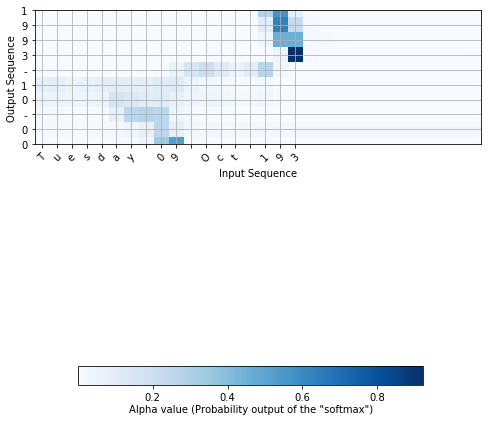

In [35]:
# The function `attention_map()` pulls out the attention values from your model and plots them.
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 193", num = 7, n_s = 64);